In [86]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Combine DataFrames").getOrCreate()

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 88, Finished, Available, Finished)

In [87]:
df = spark.read.format("csv").option("header","true").load("Files/Container General Information - Sugar Land.csv")
display(df)

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 89, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 412d4da1-f95d-4d94-9143-0335ecd51d41)

In [88]:
df2 = spark.read.format("csv").option("header","true").load("Files/Container Inventory by Location - Sugar Land.csv")
display(df2)

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 90, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 9f502beb-723f-4d9a-b07f-b75032f486b3)

In [89]:
df3 = spark.read.format("csv").option("header","true").load("Files/Container Product Detail - Sugar Land.csv")
display(df3)

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 91, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 2ac502d9-e4b6-4c99-93ba-2fdfa1f4a823)

In [90]:
df4 = spark.read.format("csv").option("header","true").load("Files/Instrument Items Missing From Container - Sugar Land.csv")
display(df4)

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 92, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 963dcda0-440c-436e-b7ff-caa45517a0c1)

In [91]:
df5 = spark.read.format("csv").option("header","true").load("Files/Sterilization Container Level - Sugar Land.csv")
display(df5)

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 93, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 986e3fb2-8cb3-4814-9804-ea9978167341)

In [92]:
from pyspark.sql import functions as F, types as T, Window

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 94, Finished, Available, Finished)

In [93]:
# ---------- helpers ----------
def pick_ci(cols, *opts):
    low = {c.lower(): c for c in cols}
    for o in opts:
        if o and o.lower() in low:
            return low[o.lower()]
    return None

def norm_key(col):
    # trim -> collapse spaces -> drop non-alnum -> UPPER
    return F.upper(
        F.regexp_replace(
            F.regexp_replace(F.trim(col), r"\s+", " "),
            r"[^0-9A-Za-z]", ""
        )
    )


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 95, Finished, Available, Finished)

In [94]:
# ---------- 1) Build the container "dimension" (bridge) from INVENTORY (df2) ----------
inv_name = pick_ci(df2.columns, "Container Name","Name")
inv_act  = pick_ci(df2.columns, "Container Actual","Actual Container","Actual")
inv_bar  = pick_ci(df2.columns, "Container Barcode","Barcode","Serial","Container Serial Number")
inv_idx  = pick_ci(df2.columns, "Container Index","Container ID")  # your new ID (if present)

inv_dim = (df2
    .withColumn("NameKey",   norm_key(F.col(inv_name))  if inv_name else F.lit(None))
    .withColumn("ActualKey", norm_key(F.col(inv_act))   if inv_act  else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(inv_bar))   if inv_bar  else F.lit(None))
)

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 96, Finished, Available, Finished)

In [95]:
# If df2 already has your Container Index, reuse it; otherwise create a stable ID from keys
if inv_idx:
    inv_dim = inv_dim.withColumn("ContainerIndex", F.col(inv_idx).cast("string"))
else:
    # stable, reproducible 16-char id based on the 3 keys
    inv_dim = inv_dim.withColumn(
        "ContainerIndex",
        F.sha2(F.concat_ws("|", F.col("NameKey"), F.col("ActualKey"), F.col("SerialKey")), 256).substr(1, 16)
    )

# Keep one row per physical container index (in case inventory has duplicates)
container_dim = (inv_dim
    .select("ContainerIndex","NameKey","ActualKey","SerialKey")
    .dropna(subset=["ContainerIndex"])
    .dropDuplicates(["ContainerIndex"])
    .cache()
)

print("Container dimension rows:", container_dim.count())

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 97, Finished, Available, Finished)

Container dimension rows: 9996


In [96]:
from pyspark.sql import functions as F

# ---------- GI: add ContainerIndex (SerialKey → NameKey fallback) ----------
gi_name = pick_ci(df.columns, "Container Name","Name")
gi_bar  = pick_ci(df.columns, "Container Barcode","Barcode","Serial","Container Serial Number")

gi_keyed = (df
    .withColumn("NameKey",   norm_key(F.col(gi_name)) if gi_name else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(gi_bar))  if gi_bar  else F.lit(None))
)

# 1) If GI already has a ContainerIndex-like column, rename it to avoid clashes
gi_existing_idx = "ContainerIndex" if "ContainerIndex" in gi_keyed.columns else None
if gi_existing_idx:
    gi_keyed = gi_keyed.withColumnRenamed("ContainerIndex", "GI_ContainerIndex")

gi_with_idx = (gi_keyed.alias("gi")
    # CI by Serial
    .join(
        container_dim.select(
            F.col("SerialKey").alias("jSerial"),
            F.col("ContainerIndex").alias("CI_bySerial")
        ),
        on=F.col("gi.SerialKey")==F.col("jSerial"),
        how="left"
    )
    # CI by Name
    .join(
        container_dim.select(
            F.col("NameKey").alias("jName"),
            F.col("ContainerIndex").alias("CI_byName")
        ),
        on=F.col("gi.NameKey")==F.col("jName"),
        how="left"
    )
    # prefer existing GI index (if it existed), else Serial, else Name
    .withColumn(
        "ContainerIndex",
        F.coalesce(
            F.col("GI_ContainerIndex") if "GI_ContainerIndex" in gi_keyed.columns else F.lit(None),
            F.col("CI_bySerial"),
            F.col("CI_byName")
        )
    )
    .drop("jSerial","jName","CI_bySerial","CI_byName","GI_ContainerIndex")
    .cache()
)

print(
    "GI rows:", gi_with_idx.count(),
    "| with ContainerIndex:", gi_with_idx.filter(F.col("ContainerIndex").isNotNull()).count()
)

# ---------- ST: add ContainerIndex (SerialKey → ActualKey → NameKey) ----------
st_name = pick_ci(df5.columns, "Container Name","Name")
st_act  = pick_ci(df5.columns, "Container Actual","Actual Container","Actual")
st_bar  = pick_ci(df5.columns, "Container Barcode","Barcode","Serial","Container Serial Number")

st_keyed = (df5
    .withColumn("NameKey",   norm_key(F.col(st_name)) if st_name else F.lit(None))
    .withColumn("ActualKey", norm_key(F.col(st_act))  if st_act  else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(st_bar))  if st_bar  else F.lit(None))
)

# If ST already has a ContainerIndex, rename it first
if "ContainerIndex" in st_keyed.columns:
    st_keyed = st_keyed.withColumnRenamed("ContainerIndex", "ST_ContainerIndex")

st_with_idx = (st_keyed.alias("st")
    # CI by Serial
    .join(
        container_dim.select(
            F.col("SerialKey").alias("jSerial"),
            F.col("ContainerIndex").alias("CI_bySerial")
        ),
        on=F.col("st.SerialKey")==F.col("jSerial"),
        how="left"
    )
    # CI by Actual
    .join(
        container_dim.select(
            F.col("ActualKey").alias("jActual"),
            F.col("ContainerIndex").alias("CI_byActual")
        ),
        on=F.col("st.ActualKey")==F.col("jActual"),
        how="left"
    )
    # CI by Name
    .join(
        container_dim.select(
            F.col("NameKey").alias("jName"),
            F.col("ContainerIndex").alias("CI_byName")
        ),
        on=F.col("st.NameKey")==F.col("jName"),
        how="left"
    )
    .withColumn(
        "ContainerIndex",
        F.coalesce(
            F.col("ST_ContainerIndex") if "ST_ContainerIndex" in st_keyed.columns else F.lit(None),
            F.col("CI_bySerial"), F.col("CI_byActual"), F.col("CI_byName")
        )
    )
    .drop("jSerial","jActual","jName","CI_bySerial","CI_byActual","CI_byName","ST_ContainerIndex")
    .cache()
)

print(
    "ST rows:", st_with_idx.count(),
    "| with ContainerIndex:", st_with_idx.filter(F.col("ContainerIndex").isNotNull()).count()
)

# sanity peek
display(gi_with_idx.select("ContainerIndex","NameKey","SerialKey").limit(10))
display(st_with_idx.select("ContainerIndex","SerialKey","ActualKey","NameKey").limit(10))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 98, Finished, Available, Finished)

GI rows: 7573 | with ContainerIndex: 4707
ST rows: 65150 | with ContainerIndex: 0


SynapseWidget(Synapse.DataFrame, e2967a40-97e2-4b3d-b91b-d5c2cf722907)

SynapseWidget(Synapse.DataFrame, e23b06f2-99ed-4738-b85e-b37ba3937022)

In [97]:
from pyspark.sql import functions as F

def null_if_blank(c):
    return F.when(F.trim(F.col(c)).isin("", "BLANK", "NULL", "N/A", "NA"), None).otherwise(F.col(c))

# If df2 already has a Container Index column, clean it
if "Container Index" in df2.columns:
    df2 = df2.withColumn("Container Index", null_if_blank("Container Index"))

# Also clean any ContainerIndex columns that may already exist in df / df5
if "ContainerIndex" in df.columns:
    df = df.withColumn("ContainerIndex", null_if_blank("ContainerIndex"))
if "ContainerIndex" in df5.columns:
    df5 = df5.withColumn("ContainerIndex", null_if_blank("ContainerIndex"))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 99, Finished, Available, Finished)

In [98]:
# (re)make your keys for df2 and the dimension
inv_name = pick_ci(df2.columns, "Container Name","Name")
inv_act  = pick_ci(df2.columns, "Container Actual","Actual Container","Actual")
inv_bar  = pick_ci(df2.columns, "Container Barcode","Barcode","Serial","Container Serial Number")
inv_idx  = pick_ci(df2.columns, "Container Index","Container ID")

inv_dim = (df2
    .withColumn("NameKey",   norm_key(F.col(inv_name))  if inv_name else F.lit(None))
    .withColumn("ActualKey", norm_key(F.col(inv_act))   if inv_act  else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(inv_bar))   if inv_bar  else F.lit(None))
)

# Prefer your provided Container Index (0..9996) IF it's non-empty; otherwise generate
if inv_idx:
    inv_dim = inv_dim.withColumn("ContainerIndex_src", null_if_blank(inv_idx))
else:
    inv_dim = inv_dim.withColumn("ContainerIndex_src", F.lit(None))

inv_dim = inv_dim.withColumn(
    "ContainerIndex",
    F.coalesce(
        F.col("ContainerIndex_src"),
        F.sha2(F.concat_ws("|", F.col("NameKey"), F.col("ActualKey"), F.col("SerialKey")), 256).substr(1, 16)
    )
)

container_dim = (inv_dim
    .select("ContainerIndex","NameKey","ActualKey","SerialKey")
    .dropna(subset=["ContainerIndex"])
    .dropDuplicates(["ContainerIndex"])
    .cache()
)

print("container_dim:", container_dim.count())
display(container_dim.limit(10))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 100, Finished, Available, Finished)

container_dim: 9996


SynapseWidget(Synapse.DataFrame, 1c0e9071-2cf9-48ad-9832-15acce14ae15)

In [99]:
# ST
st_name  = pick_ci(df5.columns, "Container","Container Name","Name")
st_bar   = pick_ci(df5.columns, "Container Serial Number","Container Barcode","Barcode","Serial")
st_actual= pick_ci(df5.columns, "Container Actual","Actual")

st_keyed = (df5
    .withColumn("NameKey",   norm_key(F.col(st_name))  if st_name  else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(st_bar))   if st_bar   else F.lit(None))
    .withColumn("ActualKey", norm_key(F.col(st_actual))if st_actual else F.lit(None))
)

# Always create ST_ContainerIndex
if "ContainerIndex" in st_keyed.columns:
    st_keyed = st_keyed.withColumn("ST_ContainerIndex", null_if_blank("ContainerIndex")).drop("ContainerIndex")
else:
    st_keyed = st_keyed.withColumn("ST_ContainerIndex", F.lit(None))

st_with_idx = (st_keyed.alias("st")
    .join(container_dim.select(F.col("SerialKey").alias("jSerial"), F.col("ContainerIndex").alias("CI_bySerial")),
          F.col("st.SerialKey")==F.col("jSerial"), "left")
    .join(container_dim.select(F.col("ActualKey").alias("jActual"), F.col("ContainerIndex").alias("CI_byActual")),
          F.col("st.ActualKey")==F.col("jActual"), "left")
    .join(container_dim.select(F.col("NameKey").alias("jName"), F.col("ContainerIndex").alias("CI_byName")),
          F.col("st.NameKey")==F.col("jName"), "left")
    .withColumn("ContainerIndex", 
                F.coalesce(F.col("ST_ContainerIndex"), F.col("CI_bySerial"), F.col("CI_byActual"), F.col("CI_byName")))
    .drop("ST_ContainerIndex","jSerial","jActual","jName","CI_bySerial","CI_byActual","CI_byName")
    .cache()
)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 101, Finished, Available, Finished)

In [100]:
# GI
gi_name = pick_ci(df.columns, "Container Name","Name")
gi_bar  = pick_ci(df.columns, "Container Barcode","Barcode","Serial","Container Serial Number")

gi_keyed = (df
    .withColumn("NameKey",   norm_key(F.col(gi_name)) if gi_name else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(gi_bar))  if gi_bar  else F.lit(None))
)

# Always create GI_ContainerIndex so later code doesn’t break
if "ContainerIndex" in gi_keyed.columns:
    gi_keyed = gi_keyed.withColumn("GI_ContainerIndex", null_if_blank("ContainerIndex")).drop("ContainerIndex")
else:
    gi_keyed = gi_keyed.withColumn("GI_ContainerIndex", F.lit(None))

gi_with_idx = (gi_keyed.alias("gi")
    .join(container_dim.select(F.col("SerialKey").alias("jSerial"), F.col("ContainerIndex").alias("CI_bySerial")),
          F.col("gi.SerialKey")==F.col("jSerial"), "left")
    .join(container_dim.select(F.col("NameKey").alias("jName"), F.col("ContainerIndex").alias("CI_byName")),
          F.col("gi.NameKey")==F.col("jName"), "left")
    .withColumn("ContainerIndex", 
                F.coalesce(F.col("GI_ContainerIndex"), F.col("CI_bySerial"), F.col("CI_byName")))
    .drop("GI_ContainerIndex","jSerial","jName","CI_bySerial","CI_byName")
    .cache()
)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 102, Finished, Available, Finished)

In [101]:
def csum(df):
    return df.count()

print("GI total:", gi_with_idx.count(),
      "| with index:", gi_with_idx.filter(F.col("ContainerIndex").isNotNull()).count())

print("ST total:", st_with_idx.count(),
      "| with index:", st_with_idx.filter(F.col("ContainerIndex").isNotNull()).count())

# Where GI index is null — check which keys are missing
gi_null = gi_with_idx.filter(F.col("ContainerIndex").isNull())
print("GI null index:", gi_null.count())
display(
    gi_null
    .select(
        F.when(F.col("SerialKey").isNull(), "SERIAL_NULL").otherwise("SERIAL_OK").alias("SerialState"),
        F.when(F.col("NameKey").isNull(),   "NAME_NULL").otherwise("NAME_OK").alias("NameState")
    )
    .groupBy("SerialState","NameState").count().orderBy(F.desc("count"))
)

# Where ST index is null — check which keys are missing
st_null = st_with_idx.filter(F.col("ContainerIndex").isNull())
print("ST null index:", st_null.count())
display(
    st_null
    .select(
        F.when(F.col("SerialKey").isNull(), "SERIAL_NULL").otherwise("SERIAL_OK").alias("SerialState"),
        F.when(F.col("ActualKey").isNull(), "ACTUAL_NULL").otherwise("ACTUAL_OK").alias("ActualState"),
        F.when(F.col("NameKey").isNull(),   "NAME_NULL").otherwise("NAME_OK").alias("NameState")
    )
    .groupBy("SerialState","ActualState","NameState").count().orderBy(F.desc("count"))
)



StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 103, Finished, Available, Finished)

GI total: 7573 | with index: 4707
ST total: 65152 | with index: 6
GI null index: 2866


SynapseWidget(Synapse.DataFrame, 9b1b7746-0a38-4031-8350-75328c9312fe)

ST null index: 65146


SynapseWidget(Synapse.DataFrame, 78d0b23a-73b0-4ba6-b5b5-259dcf5b2583)

In [102]:
from pyspark.sql import functions as F

# -------- helpers: robust column pickers --------
def pick_ci(cols, *candidates):
    cl = [c.strip().lower() for c in cols]
    for cand in candidates:
        if cand is None: 
            continue
        i = next((i for i, x in enumerate(cl) if x == cand.strip().lower()), None)
        if i is not None: 
            return cols[i]
    return None

def null_if_blank(colname):
    return F.when(F.trim(F.col(colname)).isin("", "BLANK", "NULL", "N/A", "NA"), None).otherwise(F.col(colname))

# -------- 1) Build st_keyed robustly --------
st_name   = pick_ci(df5.columns, "Container", "Container Name", "Name")
st_bar    = pick_ci(df5.columns, "Container Serial Number", "Container Barcode", "Barcode", "Serial")
st_actual = pick_ci(df5.columns, "Container Actual", "Actual")

st_keyed = df5
st_keyed = st_keyed.withColumn("NameKey",   F.lit(None) if not st_name   else F.upper(F.regexp_replace(F.regexp_replace(F.trim(F.col(st_name)),  r"\s+", " "), r"[^0-9A-Za-z]", "")))
st_keyed = st_keyed.withColumn("SerialKey", F.lit(None) if not st_bar    else F.upper(F.regexp_replace(F.regexp_replace(F.trim(F.col(st_bar)),   r"\s+", " "), r"[^0-9A-Za-z]", "")))
st_keyed = st_keyed.withColumn("ActualKey", F.lit(None) if not st_actual else F.upper(F.regexp_replace(F.regexp_replace(F.trim(F.col(st_actual)), r"\s+", " "), r"[^0-9A-Za-z]", "")))

# always create ST_ContainerIndex so coalesce can't fail later
if "ST_ContainerIndex" not in st_keyed.columns:
    if "ContainerIndex" in st_keyed.columns:   # if ST already brought one in, sanitize it
        st_keyed = st_keyed.withColumn("ST_ContainerIndex", null_if_blank("ContainerIndex")).drop("ContainerIndex")
    else:
        st_keyed = st_keyed.withColumn("ST_ContainerIndex", F.lit(None))

print("st_keyed columns:", st_keyed.columns[:20], "...")
st_keyed.select("NameKey","ActualKey","SerialKey","ST_ContainerIndex").show(5, truncate=False)

# -------- 2) Do the ContainerIndex resolution join --------
# container_dim must contain: ContainerIndex, SerialKey, ActualKey, NameKey
st_with_idx = (st_keyed.alias("st")
    .join(container_dim.select(F.col("SerialKey").alias("jSerial"),
                               F.col("ContainerIndex").alias("CI_bySerial")),
          F.col("st.SerialKey")==F.col("jSerial"), "left")
    .join(container_dim.select(F.col("ActualKey").alias("jActual"),
                               F.col("ContainerIndex").alias("CI_byActual")),
          F.col("st.ActualKey")==F.col("jActual"), "left")
    .join(container_dim.select(F.col("NameKey").alias("jName"),
                               F.col("ContainerIndex").alias("CI_byName")),
          F.col("st.NameKey")==F.col("jName"), "left")
    .withColumn(
        "ContainerIndex",
        F.coalesce(F.col("ST_ContainerIndex"), F.col("CI_bySerial"), F.col("CI_byActual"), F.col("CI_byName"))
    )
    .drop("ST_ContainerIndex","jSerial","jActual","jName","CI_bySerial","CI_byActual","CI_byName")
    .cache()
)

# quick check
print("ST rows:", st_with_idx.count(),
      "| with ContainerIndex:", st_with_idx.filter(F.col("ContainerIndex").isNotNull()).count())
st_with_idx.select("ContainerIndex","SerialKey","ActualKey","NameKey").show(10, truncate=False)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 104, Finished, Available, Finished)

st_keyed columns: ['Sterilized Date/Time', 'Facility', 'Sterilizer', 'Scanned by (ID)', 'Container', 'Load Result', 'Container Serial Number', 'Cycle', 'Packaging Type', 'Physician', 'Reference Number', 'Service', 'Sterilization Method', 'NameKey', 'SerialKey', 'ActualKey', 'ST_ContainerIndex'] ...
+------------------------------------+---------+---------+-----------------+
|NameKey                             |ActualKey|SerialKey|ST_ContainerIndex|
+------------------------------------+---------+---------+-----------------+
|HHSETSPDTESTSTEAMBOWIEDICKTEST001   |NULL     |BLANK    |NULL             |
|HHSETSPDTESTSTEAMBOWIEDICKTEST001   |NULL     |BLANK    |NULL             |
|HHSETSPDTESTSTEAMBOWIEDICKTEST001   |NULL     |BLANK    |NULL             |
|LOANERARTHREXMINIFRAGINSTRUMENTS8   |NULL     |BLANK    |NULL             |
|SGSETGENLAPAROSCOPICINSTRUMENTSET005|NULL     |BLANK    |NULL             |
+------------------------------------+---------+---------+-----------------+
only sh

In [103]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# --- 0) FORCE the column to exist on st_keyed (no ifs) ---
# Do this right after you build st_keyed (with NameKey/SerialKey/ActualKey) and BEFORE any joins.
st_keyed = st_keyed.withColumn("ST_ContainerIndex", F.lit(None).cast(StringType()))

# If your raw df5 has some flavor of container index, fold it in (case/space-insensitive), then drop raw columns
raw_idx_cols = [c for c in st_keyed.columns if c.lower().strip() in ("container index", "containerindex")]
for c in raw_idx_cols:
    st_keyed = st_keyed.withColumn("ST_ContainerIndex",
                                   F.coalesce(F.when(F.trim(F.col(c)).isin("", "BLANK", "NULL", "N/A", "NA"), None)
                                              .otherwise(F.col(c)),
                                              F.col("ST_ContainerIndex"))).drop(c)

# --- 1) sanity: prove ST_ContainerIndex is present BEFORE the join ---
print("has ST_ContainerIndex? ->", "ST_ContainerIndex" in st_keyed.columns)
st_keyed.select("NameKey","ActualKey","SerialKey","ST_ContainerIndex").show(5, truncate=False)

# --- 2) now do the join to resolve the final ContainerIndex ---
st_with_idx = (st_keyed.alias("st")
    .join(container_dim.select(F.col("SerialKey").alias("jSerial"),
                               F.col("ContainerIndex").alias("CI_bySerial")),
          F.col("st.SerialKey")==F.col("jSerial"), "left")
    .join(container_dim.select(F.col("ActualKey").alias("jActual"),
                               F.col("ContainerIndex").alias("CI_byActual")),
          F.col("st.ActualKey")==F.col("jActual"), "left")
    .join(container_dim.select(F.col("NameKey").alias("jName"),
                               F.col("ContainerIndex").alias("CI_byName")),
          F.col("st.NameKey")==F.col("jName"), "left")
    .withColumn("ContainerIndex",
                F.coalesce(F.col("ST_ContainerIndex"), F.col("CI_bySerial"), F.col("CI_byActual"), F.col("CI_byName")))
    .drop("ST_ContainerIndex","jSerial","jActual","jName","CI_bySerial","CI_byActual","CI_byName")
    .cache()
)

print("ST rows:", st_with_idx.count(),
      "| with ContainerIndex:", st_with_idx.filter(F.col("ContainerIndex").isNotNull()).count())


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 105, Finished, Available, Finished)

has ST_ContainerIndex? -> True
+------------------------------------+---------+---------+-----------------+
|NameKey                             |ActualKey|SerialKey|ST_ContainerIndex|
+------------------------------------+---------+---------+-----------------+
|HHSETSPDTESTSTEAMBOWIEDICKTEST001   |NULL     |BLANK    |NULL             |
|HHSETSPDTESTSTEAMBOWIEDICKTEST001   |NULL     |BLANK    |NULL             |
|HHSETSPDTESTSTEAMBOWIEDICKTEST001   |NULL     |BLANK    |NULL             |
|LOANERARTHREXMINIFRAGINSTRUMENTS8   |NULL     |BLANK    |NULL             |
|SGSETGENLAPAROSCOPICINSTRUMENTSET005|NULL     |BLANK    |NULL             |
+------------------------------------+---------+---------+-----------------+
only showing top 5 rows

ST rows: 65152 | with ContainerIndex: 6


In [104]:
print(st_keyed.columns)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 106, Finished, Available, Finished)

['Sterilized Date/Time', 'Facility', 'Sterilizer', 'Scanned by (ID)', 'Container', 'Load Result', 'Container Serial Number', 'Cycle', 'Packaging Type', 'Physician', 'Reference Number', 'Service', 'Sterilization Method', 'NameKey', 'SerialKey', 'ActualKey', 'ST_ContainerIndex']


In [105]:
st_keyed.printSchema()


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 107, Finished, Available, Finished)

root
 |-- Sterilized Date/Time: string (nullable = true)
 |-- Facility: string (nullable = true)
 |-- Sterilizer: string (nullable = true)
 |-- Scanned by (ID): string (nullable = true)
 |-- Container: string (nullable = true)
 |-- Load Result: string (nullable = true)
 |-- Container Serial Number: string (nullable = true)
 |-- Cycle: string (nullable = true)
 |-- Packaging Type: string (nullable = true)
 |-- Physician: string (nullable = true)
 |-- Reference Number: string (nullable = true)
 |-- Service: string (nullable = true)
 |-- Sterilization Method: string (nullable = true)
 |-- NameKey: string (nullable = true)
 |-- SerialKey: string (nullable = true)
 |-- ActualKey: void (nullable = true)
 |-- ST_ContainerIndex: string (nullable = true)



In [106]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# Helper: normalized key
def norm_key(col):
    return F.upper(
        F.regexp_replace(
            F.regexp_replace(F.trim(col), r"\s+", " "),
            r"[^0-9A-Za-z]", ""
        )
    )

# ---------- 1) Build st_keyed with the correct name column ----------
if "Container" in df5.columns:
    st_name_col = "Container"
else:
    # fallback if the file ever changes
    st_name_col = next((c for c in df5.columns if c.lower().strip() in ("container name","name")), None)

st_bar_col    = next((c for c in df5.columns if c.lower().strip() in
                      ("container serial number","container barcode","barcode","serial")), None)
st_actual_col = next((c for c in df5.columns if c.lower().strip() in
                      ("container actual","actual")), None)

st_keyed = (df5
    .withColumn("NameKey",   norm_key(F.col(st_name_col))   if st_name_col   else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(st_bar_col))    if st_bar_col    else F.lit(None))
    .withColumn("ActualKey", norm_key(F.col(st_actual_col)) if st_actual_col else F.lit(None))
)

# ---------- 2) Guarantee ST_ContainerIndex exists BEFORE joins ----------
st_keyed = st_keyed.withColumn("ST_ContainerIndex", F.lit(None).cast(StringType()))
raw_idx_cols = [c for c in st_keyed.columns if c.lower().strip() in ("container index","containerindex")]
for c in raw_idx_cols:
    st_keyed = (st_keyed
        .withColumn("ST_ContainerIndex",
                    F.coalesce(
                        F.when(F.trim(F.col(c)).isin("", "BLANK", "NULL", "N/A", "NA"), None).otherwise(F.col(c)),
                        F.col("ST_ContainerIndex")
                    ))
        .drop(c)
    )

# Quick sanity so you can see it's populated
print("Sterilization key sources → name:", st_name_col, "| serial:", st_bar_col, "| actual:", st_actual_col)
st_keyed.select("NameKey","SerialKey","ActualKey","ST_ContainerIndex").show(5, truncate=False)

# ---------- 3) Resolve final ContainerIndex from container_dim ----------
# container_dim must have ContainerIndex, SerialKey, ActualKey, NameKey
st_with_idx = (st_keyed.alias("st")
    .join(container_dim.select(F.col("SerialKey").alias("jSerial"),
                               F.col("ContainerIndex").alias("CI_bySerial")),
          F.col("st.SerialKey")==F.col("jSerial"), "left")
    .join(container_dim.select(F.col("ActualKey").alias("jActual"),
                               F.col("ContainerIndex").alias("CI_byActual")),
          F.col("st.ActualKey")==F.col("jActual"), "left")
    .join(container_dim.select(F.col("NameKey").alias("jName"),
                               F.col("ContainerIndex").alias("CI_byName")),
          F.col("st.NameKey")==F.col("jName"), "left")
    .withColumn(
        "ContainerIndex",
        F.coalesce(F.col("ST_ContainerIndex"), F.col("CI_bySerial"), F.col("CI_byActual"), F.col("CI_byName"))
    )
    .drop("ST_ContainerIndex","jSerial","jActual","jName","CI_bySerial","CI_byActual","CI_byName")
    .cache()
)

# Health check
print("ST rows:", st_with_idx.count(),
      "| with ContainerIndex:", st_with_idx.filter(F.col("ContainerIndex").isNotNull()).count())


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 108, Finished, Available, Finished)

Sterilization key sources → name: Container | serial: Container Serial Number | actual: None
+------------------------------------+---------+---------+-----------------+
|NameKey                             |SerialKey|ActualKey|ST_ContainerIndex|
+------------------------------------+---------+---------+-----------------+
|HHSETSPDTESTSTEAMBOWIEDICKTEST001   |BLANK    |NULL     |NULL             |
|HHSETSPDTESTSTEAMBOWIEDICKTEST001   |BLANK    |NULL     |NULL             |
|HHSETSPDTESTSTEAMBOWIEDICKTEST001   |BLANK    |NULL     |NULL             |
|LOANERARTHREXMINIFRAGINSTRUMENTS8   |BLANK    |NULL     |NULL             |
|SGSETGENLAPAROSCOPICINSTRUMENTSET005|BLANK    |NULL     |NULL             |
+------------------------------------+---------+---------+-----------------+
only showing top 5 rows

ST rows: 65152 | with ContainerIndex: 6


In [107]:
# 0) Safe helpers (use once near the top)
from pyspark.sql import functions as F

def pick_ci(cols, *candidates):
    lc = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand and cand.lower() in lc:
            return lc[cand.lower()]
    return None

def null_if_blank(colname):
    return F.when(F.trim(F.col(colname)).isin("", "BLANK", "NULL", "N/A", "NA"), F.lit(None)) \
            .otherwise(F.col(colname))

def norm_key(col):
    # uppercase, collapse spaces to single, strip non-alnum
    return F.upper(F.regexp_replace(F.regexp_replace(F.trim(col), r"\s+", " "), r"[^0-9A-Za-z]", ""))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 109, Finished, Available, Finished)

In [108]:
# 1) Dimension: dim_container (from df2)
# Columns that might exist in df2
inv_name  = pick_ci(df2.columns, "Container Name", "Name")
inv_act   = pick_ci(df2.columns, "Container Actual", "Actual Container")
inv_bar   = pick_ci(df2.columns, "Container Barcode", "Barcode", "Container Serial Number", "Serial")
inv_cidx  = pick_ci(df2.columns, "Container Index", "ContainerIndex")

dim_container = (df2
    .withColumn("NameKey",   norm_key(F.col(inv_name))                    if inv_name else F.lit(None))
    .withColumn("ActualKey", norm_key(F.col(inv_act))                     if inv_act else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(inv_bar))                     if inv_bar else F.lit(None))
    .withColumn("ContainerIndex_src", null_if_blank(inv_cidx)             if inv_cidx else F.lit(None))
    # stable surrogate if missing: hash of keys (first 16 hex chars)
    .withColumn("ContainerIndex",
        F.coalesce(F.col("ContainerIndex_src"),
                   F.expr("substring(sha2(cast(concat_ws('|', NameKey, ActualKey, SerialKey) as binary), 256), 1, 16)"))
    )
    .dropDuplicates(["ContainerIndex"])  # 1 row per container
    .cache()
)

print("dim_container:", dim_container.count(), "rows")


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 110, Finished, Available, Finished)

dim_container: 9996 rows


In [109]:
# 2) Map ContainerIndex into each domain DF (GI, PD, ST, MI)
# 2a) General Info (df → gi_with_idx)
gi_name   = pick_ci(df.columns, "Container Name", "Name")
gi_bar    = pick_ci(df.columns, "Container Barcode", "Barcode", "Serial", "Container Serial Number")

gi_keyed = (df
    .withColumn("NameKey",   norm_key(F.col(gi_name)) if gi_name else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(gi_bar))  if gi_bar  else F.lit(None))
)

# defensive: preserve any incoming ContainerIndex (if present)
if "ContainerIndex" in gi_keyed.columns:
    gi_keyed = gi_keyed.withColumn("GI_ContainerIndex", null_if_blank("ContainerIndex")).drop("ContainerIndex")
else:
    gi_keyed = gi_keyed.withColumn("GI_ContainerIndex", F.lit(None))

gi_with_idx = (gi_keyed.alias("gi")
    .join(dim_container.select(F.col("SerialKey").alias("jSerial"), F.col("ContainerIndex").alias("CI_bySerial")),
          F.col("gi.SerialKey")==F.col("jSerial"), "left")
    .join(dim_container.select(F.col("NameKey").alias("jName"),   F.col("ContainerIndex").alias("CI_byName")),
          F.col("gi.NameKey")==F.col("jName"),   "left")
    .withColumn("ContainerIndex", F.coalesce(F.col("GI_ContainerIndex"), F.col("CI_bySerial"), F.col("CI_byName")))
    .drop("GI_ContainerIndex","jSerial","jName","CI_bySerial","CI_byName")
    .cache()
)

print("GI rows:", gi_with_idx.count(),
      "| mapped ContainerIndex:", gi_with_idx.filter(F.col("ContainerIndex").isNotNull()).count())


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 111, Finished, Available, Finished)

GI rows: 7573 | mapped ContainerIndex: 4707


In [110]:
# 2b) Product Detail (df3 → pd_with_idx) — by NameKey first
pd_name = pick_ci(df3.columns, "Container Name", "Container", "Name")
pd_keyed = df3.withColumn("NameKey", norm_key(F.col(pd_name)) if pd_name else F.lit(None))

pd_with_idx = (pd_keyed.alias("pd")
    .join(dim_container.select(F.col("NameKey").alias("jName"), F.col("ContainerIndex").alias("CI_byName")),
          F.col("pd.NameKey")==F.col("jName"), "left")
    .withColumn("ContainerIndex", F.col("CI_byName"))
    .drop("jName","CI_byName")
    .cache()
)

print("PD rows:", pd_with_idx.count(),
      "| mapped ContainerIndex:", pd_with_idx.filter(F.col("ContainerIndex").isNotNull()).count())


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 112, Finished, Available, Finished)

PD rows: 29499 | mapped ContainerIndex: 27897


In [111]:
# 2c) Sterilization (df5 → st_with_idx) — column is Container 
st_cont = pick_ci(df5.columns, "Container")  # per your note
st_bar  = pick_ci(df5.columns, "Container Serial Number", "Container Barcode", "Serial")

st_keyed = (df5
    .withColumn("NameKey",   norm_key(F.col(st_cont)) if st_cont else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(st_bar))  if st_bar  else F.lit(None))
    # ST doesn't carry Actual in your files; keep as None unless you had it elsewhere
    .withColumn("ActualKey", F.lit(None))
)

# defensive rename/create for ST_ContainerIndex
if "ContainerIndex" in st_keyed.columns:
    st_keyed = st_keyed.withColumn("ST_ContainerIndex", null_if_blank("ContainerIndex")).drop("ContainerIndex")
else:
    st_keyed = st_keyed.withColumn("ST_ContainerIndex", F.lit(None))

st_with_idx = (st_keyed.alias("st")
    .join(dim_container.select(F.col("SerialKey").alias("jSerial"), F.col("ContainerIndex").alias("CI_bySerial")),
          F.col("st.SerialKey")==F.col("jSerial"), "left")
    .join(dim_container.select(F.col("ActualKey").alias("jActual"), F.col("ContainerIndex").alias("CI_byActual")),
          F.col("st.ActualKey")==F.col("jActual"), "left")
    .join(dim_container.select(F.col("NameKey").alias("jName"),   F.col("ContainerIndex").alias("CI_byName")),
          F.col("st.NameKey")==F.col("jName"), "left")
    .withColumn("ContainerIndex",
        F.coalesce(F.col("ST_ContainerIndex"), F.col("CI_bySerial"), F.col("CI_byActual"), F.col("CI_byName"))
    )
    .drop("ST_ContainerIndex","jSerial","jActual","jName","CI_bySerial","CI_byActual","CI_byName")
    .cache()
)

print("ST rows:", st_with_idx.count(),
      "| mapped ContainerIndex:", st_with_idx.filter(F.col("ContainerIndex").isNotNull()).count())


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 113, Finished, Available, Finished)

ST rows: 65152 | mapped ContainerIndex: 6


In [112]:
# 2d) Missing Items (df4 → mi_with_idx) — usually keyed by Serial or Name
mi_name = pick_ci(df4.columns, "Container Name", "Container", "Name")
mi_bar  = pick_ci(df4.columns, "Container Serial Number", "Container Barcode", "Serial")

mi_keyed = (df4
    .withColumn("NameKey",   norm_key(F.col(mi_name)) if mi_name else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(mi_bar))  if mi_bar  else F.lit(None))
)

if "ContainerIndex" in mi_keyed.columns:
    mi_keyed = mi_keyed.withColumn("MI_ContainerIndex", null_if_blank("ContainerIndex")).drop("ContainerIndex")
else:
    mi_keyed = mi_keyed.withColumn("MI_ContainerIndex", F.lit(None))

mi_with_idx = (mi_keyed.alias("mi")
    .join(dim_container.select(F.col("SerialKey").alias("jSerial"), F.col("ContainerIndex").alias("CI_bySerial")),
          F.col("mi.SerialKey")==F.col("jSerial"), "left")
    .join(dim_container.select(F.col("NameKey").alias("jName"), F.col("ContainerIndex").alias("CI_byName")),
          F.col("mi.NameKey")==F.col("jName"), "left")
    .withColumn("ContainerIndex", F.coalesce(F.col("MI_ContainerIndex"), F.col("CI_bySerial"), F.col("CI_byName")))
    .drop("MI_ContainerIndex","jSerial","jName","CI_bySerial","CI_byName")
    .cache()
)

print("MI rows:", mi_with_idx.count(),
      "| mapped ContainerIndex:", mi_with_idx.filter(F.col("ContainerIndex").isNotNull()).count())


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 114, Finished, Available, Finished)

MI rows: 447 | mapped ContainerIndex: 0


In [113]:
# 3) Facts (clean, narrow, FK + measures)
# 3a) fact_sterilization
st_ts_col  = pick_ci(st_with_idx.columns, "Sterilized Date/Time", "Start Time", "Timestamp")
load_res   = pick_ci(st_with_idx.columns, "Load Result")
sterilizer = pick_ci(st_with_idx.columns, "Sterilizer")
cycle      = pick_ci(st_with_idx.columns, "Cycle")
serv_col   = pick_ci(st_with_idx.columns, "Service")
method_col = pick_ci(st_with_idx.columns, "Sterilization Method")

fact_sterilization = (st_with_idx
    .withColumn("EventTs",
        F.to_timestamp(F.col(st_ts_col), "MM/dd/yyyy HH:mm:ss")
        if st_ts_col else F.lit(None).cast("timestamp"))
    .select(
        "ContainerIndex",
        "SerialKey","NameKey","ActualKey",
        F.col("EventTs"),
        *( [F.col(load_res).alias("LoadResult")] if load_res else [] ),
        *( [F.col(sterilizer).alias("Sterilizer")] if sterilizer else [] ),
        *( [F.col(cycle).alias("Cycle")] if cycle else [] ),
        *( [F.col(serv_col).alias("Service")] if serv_col else [] ),
        *( [F.col(method_col).alias("SterilizationMethod")] if method_col else [] ),
    )
    .filter(F.col("ContainerIndex").isNotNull())
    .cache()
)

print("fact_sterilization:", fact_sterilization.count(), "rows")


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 115, Finished, Available, Finished)

fact_sterilization: 6 rows


In [114]:
# 3b) fact_missing_items
mi_qty  = pick_ci(mi_with_idx.columns, "Qty Missing", "Quantity Missing", "Qty")
mi_item = pick_ci(mi_with_idx.columns, "Catalog Name", "Item", "Catalog Number")

fact_missing_items = (mi_with_idx
    .select(
        "ContainerIndex",
        "SerialKey","NameKey",
        *( [F.col(mi_item).alias("Item")] if mi_item else [] ),
        *( [F.col(mi_qty).cast("double").alias("QtyMissing")] if mi_qty else [] ),
    )
    .filter(F.col("ContainerIndex").isNotNull())
    .cache()
)

print("fact_missing_items:", fact_missing_items.count(), "rows")


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 116, Finished, Available, Finished)

fact_missing_items: 0 rows


In [115]:
# 4) Sanity checks (nulls & coverage)
print("dim_container null index:", dim_container.filter(F.col("ContainerIndex").isNull()).count())
print("ST rows missing index:", fact_sterilization.filter(F.col("ContainerIndex").isNull()).count())
print("MI rows missing index:", fact_missing_items.filter(F.col("ContainerIndex").isNull()).count())

# % of facts that matched the dim
total_st = st_with_idx.count()
matched_st = fact_sterilization.count()
print(f"ST match rate: {matched_st}/{total_st} ({(matched_st/total_st*100 if total_st else 0):.1f}%)")


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 117, Finished, Available, Finished)

dim_container null index: 0
ST rows missing index: 0
MI rows missing index: 0
ST match rate: 6/65152 (0.0%)


In [116]:
# 5) Quick ERD printout (ASCII)
print(r"""
+------------------+              +----------------------+
|   dim_container  |  1 ------ *  |  fact_sterilization  |
|------------------|              |----------------------|
| ContainerIndex PK|<-------------| ContainerIndex  (FK) |
| NameKey          |              | EventTs              |
| ActualKey        |              | LoadResult           |
| SerialKey        |              | Sterilizer, Cycle    |
| ...attributes... |              | Service, Method      |
+------------------+              +----------------------+

                                   +----------------------+
                                   |  fact_missing_items  |
                                   |----------------------|
                                   | ContainerIndex  (FK) |
                                   | Item                 |
                                   | QtyMissing           |
                                   +----------------------+
""")


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 118, Finished, Available, Finished)


+------------------+              +----------------------+
|   dim_container  |  1 ------ *  |  fact_sterilization  |
|------------------|              |----------------------|
| ContainerIndex PK|<-------------| ContainerIndex  (FK) |
| NameKey          |              | EventTs              |
| ActualKey        |              | LoadResult           |
| SerialKey        |              | Sterilizer, Cycle    |
| ...attributes... |              | Service, Method      |
+------------------+              +----------------------+

                                   +----------------------+
                                   |  fact_missing_items  |
                                   |----------------------|
                                   | ContainerIndex  (FK) |
                                   | Item                 |
                                   | QtyMissing           |
                                   +----------------------+



In [117]:
dupes_dim = (dim_container
    .groupBy("ContainerIndex").count()
    .filter("count > 1"))
print("Dim dupes:", dupes_dim.count())
display(dupes_dim.limit(50))

# If Dim Dupes is 0, Container Index is unique and stable

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 119, Finished, Available, Finished)

Dim dupes: 0


SynapseWidget(Synapse.DataFrame, 2939f819-f525-478d-980d-8b73c03007ad)

In [118]:
# Sterilization
st_orphans = (st_with_idx.alias("f")
    .join(dim_container.select("ContainerIndex").alias("d"), "ContainerIndex", "left_anti"))
print("Sterilization orphans:", st_orphans.count())

# Missing items
mi_orphans = (mi_with_idx.alias("f")
    .join(dim_container.select("ContainerIndex").alias("d"), "ContainerIndex", "left_anti"))
print("MissingItems orphans:", mi_orphans.count())

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 120, Finished, Available, Finished)

Sterilization orphans: 65146
MissingItems orphans: 447


In [119]:
# Key Coherence (Serial Key/Name Key/Actual Key)
# Same ContainerIndex should map to a single NameKey/ActualKey set
key_coherence = (dim_container
    .groupBy("ContainerIndex")
    .agg(F.countDistinct("NameKey").alias("n_name"),
         F.countDistinct("ActualKey").alias("n_actual"),
         F.countDistinct("SerialKey").alias("n_serial"))
    .filter((F.col("n_name") > 1) | (F.col("n_actual") > 1) | (F.col("n_serial") > 1)))
print("Key coherence issues:", key_coherence.count())
display(key_coherence.limit(50))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 121, Finished, Available, Finished)

Key coherence issues: 0


SynapseWidget(Synapse.DataFrame, 477d2860-995e-4e69-a3fd-4de422bcf82a)

In [120]:
#Coverage Rates

def coverage(label, df, col="ContainerIndex"):
    total = df.count()
    nonnull = df.filter(F.col(col).isNotNull()).count()
    pct = (nonnull/total*100 if total else 0)
    print(f"{label}: {nonnull}/{total} ({pct:.1f}%) with {col}")

coverage("dim_container", dim_container)
coverage("st_with_idx", st_with_idx)
coverage("mi_with_idx", mi_with_idx)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 122, Finished, Available, Finished)

dim_container: 9996/9996 (100.0%) with ContainerIndex
st_with_idx: 6/65152 (0.0%) with ContainerIndex
mi_with_idx: 0/447 (0.0%) with ContainerIndex


In [121]:
from pyspark.sql import functions as F

# how many keys we *could* match on
st_keys = (st_keyed
    .select(
        F.expr("count(1)").alias("rows"),
        F.expr("sum(case when SerialKey is not null then 1 else 0 end)").alias("st_serial_n"),
        F.expr("sum(case when ActualKey is not null then 1 else 0 end)").alias("st_actual_n"),
        F.expr("sum(case when NameKey   is not null then 1 else 0 end)").alias("st_name_n"),
    ))
dim_keys = (dim_container
    .select(
        F.expr("count(1)").alias("dim_rows"),
        F.expr("sum(case when SerialKey is not null then 1 else 0 end)").alias("dim_serial_n"),
        F.expr("sum(case when ActualKey is not null then 1 else 0 end)").alias("dim_actual_n"),
        F.expr("sum(case when NameKey   is not null then 1 else 0 end)").alias("dim_name_n"),
    ))
display(st_keys); display(dim_keys)

# distinct overlaps
st_serial_distinct = st_keyed.select("SerialKey").where("SerialKey is not null").distinct()
st_actual_distinct = st_keyed.select("ActualKey").where("ActualKey is not null").distinct()
dim_serial_distinct = dim_container.select("SerialKey").where("SerialKey is not null").distinct()
dim_actual_distinct = dim_container.select("ActualKey").where("ActualKey is not null").distinct()

serial_overlap = st_serial_distinct.join(dim_serial_distinct, "SerialKey", "inner").count()
actual_overlap = st_actual_distinct.join(dim_actual_distinct, "ActualKey", "inner").count()
print("Distinct Serial overlap:", serial_overlap)
print("Distinct Actual overlap:", actual_overlap)

# show some examples that DON'T match on each key
serial_anti = st_serial_distinct.join(dim_serial_distinct, "SerialKey", "left_anti").limit(20)
actual_anti = st_actual_distinct.join(dim_actual_distinct, "ActualKey", "left_anti").limit(20)
display(serial_anti); display(actual_anti)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 123, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, bf15e1b9-11d6-4178-8007-5fc5c3cd2d8f)

SynapseWidget(Synapse.DataFrame, ef76b535-3205-47a4-9d63-c25a754b4964)

Distinct Serial overlap: 0
Distinct Actual overlap: 0


SynapseWidget(Synapse.DataFrame, 1213d0bb-4da6-40e2-8afc-50230b633988)

SynapseWidget(Synapse.DataFrame, 58c7eb26-91bf-4d0b-abcb-b38e92dba41c)

In [122]:
from pyspark.sql import functions as F

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 124, Finished, Available, Finished)

In [123]:

# ---------- 1) Build keys for Sterilization (df5) ----------
st_cont   = pick_ci(df5.columns, "Container", "Container Actual", "Actual")
st_serial = pick_ci(df5.columns, "Container Serial Number", "Serial", "Barcode")

st_keyed = (df5
    .withColumn("ActualKey",  F.when(F.col(st_cont).isNotNull(),  norm_key(F.col(st_cont))).otherwise(F.lit(None)))
    .withColumn("SerialKey",  F.when(F.col(st_serial).isNotNull(), norm_key(F.col(st_serial))).otherwise(F.lit(None)))
)

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 125, Finished, Available, Finished)

In [124]:
# Optional: keep NameKey only if you truly have a name-like field in Sterilization
if "Container Name" in df5.columns:
    st_keyed = st_keyed.withColumn("NameKey", norm_key(F.col("Container Name")))
elif "NameKey" in st_keyed.columns:
    pass
else:
    st_keyed = st_keyed.withColumn("NameKey", F.lit(None))

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 126, Finished, Available, Finished)

In [125]:
# ---------- 2) Bring in ContainerIndex from the dimension ----------
# (priority: SerialKey → ActualKey → NameKey if present)
join_serial = container_dim.select(
    F.col("SerialKey").alias("jSerial"), 
    F.col("ContainerIndex").alias("CI_bySerial")
)
join_actual = container_dim.select(
    F.col("ActualKey").alias("jActual"), 
    F.col("ContainerIndex").alias("CI_byActual")
)

st_with_idx = (st_keyed.alias("st")
    .join(join_serial, F.col("st.SerialKey") == F.col("jSerial"), "left")
    .join(join_actual, F.col("st.ActualKey") == F.col("jActual"), "left")
)

# If you also want to fall back to NameKey when available:
if "NameKey" in container_dim.columns:
    join_name = container_dim.select(
        F.col("NameKey").alias("jName"),
        F.col("ContainerIndex").alias("CI_byName")
    )
    st_with_idx = st_with_idx.join(join_name, F.col("st.NameKey") == F.col("jName"), "left")
else:
    st_with_idx = st_with_idx.withColumn("CI_byName", F.lit(None))

# Build a safe coalesce list (no reference to ST_ContainerIndex unless it exists)
coalesce_cols = []
if "ST_ContainerIndex" in st_with_idx.columns:
    coalesce_cols.append(F.col("ST_ContainerIndex"))
coalesce_cols += [F.col("CI_bySerial"), F.col("CI_byActual"), F.col("CI_byName")]

st_with_idx = (st_with_idx
    .withColumn("ContainerIndex", F.coalesce(*coalesce_cols))
    .drop("jSerial","jActual","jName","CI_bySerial","CI_byActual","CI_byName")
    .cache()
)

# ---------- 3) (Optional) filter out fails here if you don’t want them downstream ----------
# If your business rule is: “Don’t count Load Result = Fail”
if "Load Result" in st_with_idx.columns:
    st_nofail = st_with_idx.filter(~F.upper(F.col("Load Result")).like("%FAIL%"))
else:
    st_nofail = st_with_idx

# ---------- 4) Quick coverage checks ----------
total_st   = st_with_idx.count()
covered_st = st_with_idx.filter(F.col("ContainerIndex").isNotNull()).count()
print(f"Sterilization rows: {covered_st}/{total_st} ({covered_st/total_st:.1%}) with ContainerIndex")

total_st_ok   = st_nofail.count()
covered_st_ok = st_nofail.filter(F.col("ContainerIndex").isNotNull()).count()
print(f"Sterilization (no FAIL) rows: {covered_st_ok}/{total_st_ok} ({covered_st_ok/total_st_ok:.1%}) with ContainerIndex")

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 127, Finished, Available, Finished)

Sterilization rows: 60842/65250 (93.2%) with ContainerIndex
Sterilization (no FAIL) rows: 58972/63336 (93.1%) with ContainerIndex


In [126]:
#Coverage Rates

def coverage(label, df, col="ContainerIndex"):
    total = df.count()
    nonnull = df.filter(F.col(col).isNotNull()).count()
    pct = (nonnull/total*100 if total else 0)
    print(f"{label}: {nonnull}/{total} ({pct:.1f}%) with {col}")

coverage("dim_container", dim_container)
coverage("st_with_idx", st_with_idx)
coverage("mi_with_idx", mi_with_idx)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 128, Finished, Available, Finished)

dim_container: 9996/9996 (100.0%) with ContainerIndex
st_with_idx: 60842/65250 (93.2%) with ContainerIndex
mi_with_idx: 0/447 (0.0%) with ContainerIndex


In [127]:
from pyspark.sql import functions as F

# how many keys we *could* match on
st_keys = (st_keyed
    .select(
        F.expr("count(1)").alias("rows"),
        F.expr("sum(case when SerialKey is not null then 1 else 0 end)").alias("st_serial_n"),
        F.expr("sum(case when ActualKey is not null then 1 else 0 end)").alias("st_actual_n"),
        F.expr("sum(case when NameKey   is not null then 1 else 0 end)").alias("st_name_n"),
    ))
dim_keys = (dim_container
    .select(
        F.expr("count(1)").alias("dim_rows"),
        F.expr("sum(case when SerialKey is not null then 1 else 0 end)").alias("dim_serial_n"),
        F.expr("sum(case when ActualKey is not null then 1 else 0 end)").alias("dim_actual_n"),
        F.expr("sum(case when NameKey   is not null then 1 else 0 end)").alias("dim_name_n"),
    ))
display(st_keys); display(dim_keys)

# distinct overlaps
st_serial_distinct = st_keyed.select("SerialKey").where("SerialKey is not null").distinct()
st_actual_distinct = st_keyed.select("ActualKey").where("ActualKey is not null").distinct()
dim_serial_distinct = dim_container.select("SerialKey").where("SerialKey is not null").distinct()
dim_actual_distinct = dim_container.select("ActualKey").where("ActualKey is not null").distinct()

serial_overlap = st_serial_distinct.join(dim_serial_distinct, "SerialKey", "inner").count()
actual_overlap = st_actual_distinct.join(dim_actual_distinct, "ActualKey", "inner").count()
print("Distinct Serial overlap:", serial_overlap)
print("Distinct Actual overlap:", actual_overlap)

# show some examples that DON'T match on each key
serial_anti = st_serial_distinct.join(dim_serial_distinct, "SerialKey", "left_anti").limit(20)
actual_anti = st_actual_distinct.join(dim_actual_distinct, "ActualKey", "left_anti").limit(20)
display(serial_anti); display(actual_anti)

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 129, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 9b56bf00-f461-48e9-90c5-04b36fbf9791)

SynapseWidget(Synapse.DataFrame, 70cedf4b-5292-45a9-86f2-6df0f5802a7f)

Distinct Serial overlap: 0
Distinct Actual overlap: 5025


SynapseWidget(Synapse.DataFrame, a6a73dd8-7652-4dce-8f0e-8cf454b681e9)

SynapseWidget(Synapse.DataFrame, 74a42a02-d085-4a0b-b898-e4d4dd939f05)

In [128]:
from pyspark.sql import functions as F

# --- 1) Build keys for Missing Instruments (df4) ---
mi_cont   = pick_ci(df4.columns, "Container", "Container Actual", "Actual")
mi_serial = pick_ci(df4.columns, "Container Serial Number", "Serial", "Barcode")
mi_name   = pick_ci(df4.columns, "Container Name", "Name")

mi_keyed = df4
if mi_cont:
    mi_keyed = mi_keyed.withColumn("ActualKey", norm_key(F.col(mi_cont)))
else:
    mi_keyed = mi_keyed.withColumn("ActualKey", F.lit(None))

if mi_serial:
    mi_keyed = mi_keyed.withColumn("SerialKey", norm_key(F.col(mi_serial)))
else:
    mi_keyed = mi_keyed.withColumn("SerialKey", F.lit(None))

if mi_name:
    mi_keyed = mi_keyed.withColumn("NameKey", norm_key(F.col(mi_name)))
else:
    mi_keyed = mi_keyed.withColumn("NameKey", F.lit(None))

# --- 2) Join to dim_container to fetch ContainerIndex ---
join_serial = container_dim.select(
    F.col("SerialKey").alias("jSerial"),
    F.col("ContainerIndex").alias("CI_bySerial")
)
join_actual = container_dim.select(
    F.col("ActualKey").alias("jActual"),
    F.col("ContainerIndex").alias("CI_byActual")
)
mi_with_idx = (mi_keyed.alias("mi")
    .join(join_serial, F.col("mi.SerialKey")==F.col("jSerial"), "left")
    .join(join_actual, F.col("mi.ActualKey")==F.col("jActual"), "left")
)

if "NameKey" in container_dim.columns:
    join_name = container_dim.select(
        F.col("NameKey").alias("jName"),
        F.col("ContainerIndex").alias("CI_byName")
    )
    mi_with_idx = mi_with_idx.join(join_name, F.col("mi.NameKey")==F.col("jName"), "left")
else:
    mi_with_idx = mi_with_idx.withColumn("CI_byName", F.lit(None))

mi_with_idx = (mi_with_idx
    .withColumn("ContainerIndex", F.coalesce(F.col("CI_bySerial"), F.col("CI_byActual"), F.col("CI_byName")))
    .drop("jSerial","jActual","jName","CI_bySerial","CI_byActual","CI_byName")
    .cache()
)

# --- 3) Coverage + diagnostics ---
total_mi   = mi_with_idx.count()
covered_mi = mi_with_idx.filter(F.col("ContainerIndex").isNotNull()).count()
print(f"MI rows: {covered_mi}/{total_mi} ({covered_mi/total_mi:.1%}) with ContainerIndex")

# Show why rows miss: expose the raw fields + normalized keys
mi_missing = mi_with_idx.filter(F.col("ContainerIndex").isNull())
cols_to_peek = [c for c in ["Container Serial Number","Container Barcode","Container","Container Actual","Container Name",
                            mi_serial, mi_cont, mi_name] if c and c in mi_with_idx.columns]
cols_to_peek = list(dict.fromkeys(cols_to_peek))  # de-dup
display(mi_missing.select(*(cols_to_peek + ["SerialKey","ActualKey","NameKey"])).limit(50))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 130, Finished, Available, Finished)

MI rows: 447/447 (100.0%) with ContainerIndex


SynapseWidget(Synapse.DataFrame, 237bf56f-f31f-492c-928b-f814b86fe665)

In [129]:
#Coverage Rates

def coverage(label, df, col="ContainerIndex"):
    total = df.count()
    nonnull = df.filter(F.col(col).isNotNull()).count()
    pct = (nonnull/total*100 if total else 0)
    print(f"{label}: {nonnull}/{total} ({pct:.1f}%) with {col}")

coverage("dim_container", dim_container)
coverage("st_with_idx", st_with_idx)
coverage("mi_with_idx", mi_with_idx)

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 131, Finished, Available, Finished)

dim_container: 9996/9996 (100.0%) with ContainerIndex
st_with_idx: 60842/65250 (93.2%) with ContainerIndex
mi_with_idx: 447/447 (100.0%) with ContainerIndex


In [130]:
### Fail the Notebook if Coverage Rates do not meet the 80% threshold

from pyspark.sql import functions as F

# ---- Settings ----
COVERAGE_THRESH = 0.80   # fail if any coverage < 80%

def coverage(df, col):
    total = df.count()
    ok = df.filter(F.col(col).isNotNull()).count()
    pct = ok / total if total else 0.0
    return ok, total, pct

# Required columns exist?
for name, df in [("container_dim", container_dim), ("st_with_idx", st_with_idx), ("mi_with_idx", mi_with_idx)]:
    if "ContainerIndex" not in df.columns:
        raise ValueError(f"{name} is missing 'ContainerIndex'")

# ---- Compute coverage ----
dim_ok, dim_total, dim_pct = coverage(container_dim, "ContainerIndex")
st_ok,  st_total,  st_pct  = coverage(st_with_idx,   "ContainerIndex")
mi_ok,  mi_total,  mi_pct  = coverage(mi_with_idx,   "ContainerIndex")

print(f"dim_container: {dim_ok}/{dim_total} ({dim_pct:.1%}) with ContainerIndex")
print(f"st_with_idx : {st_ok}/{st_total} ({st_pct:.1%}) with ContainerIndex")
print(f"mi_with_idx : {mi_ok}/{mi_total} ({mi_pct:.1%}) with ContainerIndex")

# ---- Fail-fast if under threshold ----
fail_msgs = []
if dim_pct < COVERAGE_THRESH: fail_msgs.append(f"dim_container coverage {dim_pct:.1%} < {COVERAGE_THRESH:.0%}")
if st_pct  < COVERAGE_THRESH: fail_msgs.append(f"Sterilization coverage {st_pct:.1%} < {COVERAGE_THRESH:.0%}")
if mi_pct  < COVERAGE_THRESH: fail_msgs.append(f"Missing Instruments coverage {mi_pct:.1%} < {COVERAGE_THRESH:.0%}")

if fail_msgs:
    # Optional quick diagnostics for the first failing dataset
    print("\n[Diagnostics]")
    if st_pct < COVERAGE_THRESH:
        display(st_with_idx.filter(F.col("ContainerIndex").isNull())
                .select("SerialKey","ActualKey","NameKey").limit(25))
    if mi_pct < COVERAGE_THRESH:
        display(mi_with_idx.filter(F.col("ContainerIndex").isNull())
                .select("SerialKey","ActualKey","NameKey").limit(25))
    raise RuntimeError("Coverage below threshold:\n- " + "\n- ".join(fail_msgs))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 132, Finished, Available, Finished)

dim_container: 9996/9996 (100.0%) with ContainerIndex
st_with_idx : 60842/65250 (93.2%) with ContainerIndex
mi_with_idx : 447/447 (100.0%) with ContainerIndex


In [131]:
st_with_idx.filter(F.col("ContainerIndex").isNull()) \
           .groupBy("Container") \
           .count() \
           .orderBy(F.desc("count")) \
           .show(20, False)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 133, Finished, Available, Finished)

+-------------------------------------------------------------------------------+-----+
|Container                                                                      |count|
+-------------------------------------------------------------------------------+-----+
|SG SET-GEN STRYKER CAMERA HD,LIGHT CORD & COUPLER 016                          |54   |
|GH LOANER - TRIATHLON TRITANIUM BASEPLATES AND PATELLAS INST. 6                |15   |
|HH LOANER GLOBUS SABLE INST                                                    |14   |
|SG LOANER - STRYKER ACCOLADE II GENERAL INST 6                                 |13   |
|GH LOANER - STRYKER LOANER TRIATHLON TS 3-6 REVISION TIBIAL PREP AND TRAILING 3|13   |
|MC LOANER STRYKER TRIATHLON TS 3-6 REVISION FEMORAL PREP & TRIALING 2          |11   |
|HH LOANER STRYKER RESTORATION MODULAR FINISHING TRAY 2                         |11   |
|MC LOANER TRIATHLON TS MISC REVISION INSTRUMENTS 4                             |10   |
|HH LOANER STRYKER TMC KNEE EXTR

In [132]:
from pyspark.sql import functions as F

EXCLUDE_SERVICES = [
    "LOANER",
    "STERILE PROCESSING",
    "OUTSIDE SERVICE",
    "DEPARTMENT",
    "ZZ_DATABASE CLEANUP",
]

# Use your sterilization DF name here (st_with_idx or st_final if you’ve built it)
st_src = st_with_idx  # change if your working DF is named differently

# normalize service for filtering (but keep original column as-is)
st_norm = st_src.withColumn("ServiceNorm", F.upper(F.trim(F.col("Service"))))

before = st_norm.count()

st_filtered = st_norm.filter(~F.col("ServiceNorm").isin(EXCLUDE_SERVICES)) \
                     .drop("ServiceNorm")

after = st_filtered.count()
print(f"Sterilization rows before: {before:,}  | after filter: {after:,}  | removed: {before-after:,}")

# if you want to keep going with the filtered frame:
st_clean = st_filtered


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 134, Finished, Available, Finished)

Sterilization rows before: 65,250  | after filter: 44,616  | removed: 20,634


In [133]:
patterns = ["LOANER", "STERILE PROCESSING", "OUTSIDE SERVICE", "DEPARTMENT", "ZZ_DATABASE CLEANUP"]
cond_excl = F.lit(False)
for p in patterns:
    cond_excl = cond_excl | F.col("ServiceNorm").startswith(p)

st_clean = st_norm.filter(~cond_excl).drop("ServiceNorm")


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 135, Finished, Available, Finished)

In [134]:
from pyspark.sql import functions as F

EXCLUDE_SERVICES = [
    "LOANER",
    "STERILE PROCESSING",
    "DEPARTMENT",
    "ZZ_DATABASE CLEANUP",
]

# Work from the raw PD
pd_raw = df3

# Normalize service
pd_norm = (pd_raw
    .withColumn("ServiceNorm", F.upper(F.trim(F.col("Service"))))
)

# Exact-or-prefix exclusion (handles things like "DEPARTMENT - SPD")
ex_regex = r"^(LOANER|STERILE PROCESSING|OUTSIDE SERVICE|DEPARTMENT|ZZ_DATABASE CLEANUP)\b"
pd_excluded = pd_norm.filter(F.col("ServiceNorm").rlike(ex_regex))
pd_clean    = pd_norm.filter(~F.col("ServiceNorm").rlike(ex_regex)).drop("ServiceNorm")

print("PD — before:", pd_norm.count())
print("PD — removed:", pd_excluded.count())
print("PD — after:", pd_clean.count())


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 136, Finished, Available, Finished)

PD — before: 16444
PD — removed: 3008
PD — after: 13436


In [135]:
print("Dropped (top 20 services):")
display(pd_excluded.groupBy("Service").count().orderBy(F.desc("count")).limit(20))

print("Kept (top 20 services):")
display(pd_clean.groupBy("Service").count().orderBy(F.desc("count")).limit(20))

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 137, Finished, Available, Finished)

Dropped (top 20 services):


SynapseWidget(Synapse.DataFrame, 5ba22f9a-5814-4e3b-a53f-245a14c49614)

Kept (top 20 services):


SynapseWidget(Synapse.DataFrame, 106b3512-f4f9-4758-a18a-1b5bdb9572b3)

In [136]:
# Rebuild NameKey the same way you did before
def norm_key(col):
    return F.upper(F.regexp_replace(F.regexp_replace(F.trim(col), r"\s+", " "), r"[^0-9A-Za-z]", ""))

pd_keyed = (pd_clean
    .withColumn("NameKey", norm_key(F.col("Container")))    # or "Container Name" if that’s your PD column
)

# (Optional) dedup PD if needed to avoid join blow-ups later.
# Pick the natural grain for PD — adjust keys if your notebook uses different cols.
pd_keyed = pd_keyed.dropDuplicates(["NameKey","Catalog Number","Catalog Name"])


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 138, Finished, Available, Finished)

In [137]:
# Null/blank service rates
display(pd_raw.groupBy(F.when(F.trim("Service")=="" , F.lit("BLANK"))
                       .when(F.col("Service").isNull(), F.lit("NULL"))
                       .otherwise(F.lit("POPULATED")).alias("ServiceState"))
               .count())

# Are there unexpected service labels close to your excludes?
display(pd_raw.select(F.upper(F.trim("Service")).alias("S"))
              .groupBy("S").count()
              .orderBy(F.desc("count")).limit(200))

# Compare raw vs clean by Service
raw_by_svc  = pd_raw.groupBy("Service").count().withColumnRenamed("count","raw_cnt")
clean_by_svc= pd_clean.groupBy("Service").count().withColumnRenamed("count","clean_cnt")
display(raw_by_svc.join(clean_by_svc, "Service", "outer").orderBy(F.desc("raw_cnt")))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 139, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b413ebb2-0b23-459f-beef-10ba99ae45be)

SynapseWidget(Synapse.DataFrame, 838a9095-1f53-4ba4-8976-966433559e36)

SynapseWidget(Synapse.DataFrame, 3786b64b-b1a4-4cbd-a070-beaf06017322)

In [138]:
## General Information

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 140, Finished, Available, Finished)

In [139]:
from pyspark.sql import functions as F

EXCLUDE_SERVICES = [
    "LOANER",
    "STERILE PROCESSING",
    "OUTSIDE SERVICE",
    "DEPARTMENT",
    "ZZ_DATABASE CLEANUP",
]

# Regex for exact-or-prefix match (e.g., "DEPARTMENT - SPD", "Loaner – Stryker", etc.)
ex_regex = r"^(LOANER|STERILE PROCESSING|OUTSIDE SERVICE|DEPARTMENT|ZZ_DATABASE CLEANUP)\b"

gi_raw = df

gi_norm = (gi_raw
    .withColumn("ServiceNorm", F.upper(F.trim(F.col("Service"))))
)

gi_excluded = gi_norm.filter(F.col("ServiceNorm").rlike(ex_regex))
gi_clean    = gi_norm.filter(~F.col("ServiceNorm").rlike(ex_regex)).drop("ServiceNorm")

print("GI — before:", gi_norm.count())
print("GI — removed:", gi_excluded.count())
print("GI — after:", gi_clean.count())


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 141, Finished, Available, Finished)

GI — before: 447
GI — removed: 2
GI — after: 445


In [140]:
print("Dropped (top 20 services):")
display(gi_excluded.groupBy("Service").count().orderBy(F.desc("count")).limit(20))

print("Kept (top 20 services):")
display(gi_clean.groupBy("Service").count().orderBy(F.desc("count")).limit(20))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 142, Finished, Available, Finished)

Dropped (top 20 services):


SynapseWidget(Synapse.DataFrame, 85d00086-5ca4-4ac5-8a7f-2e5eadbefafb)

Kept (top 20 services):


SynapseWidget(Synapse.DataFrame, fb2517f3-753c-4fea-9491-769348ebaf34)

In [141]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
import re

# ---------------------------------------------
# 0) Utilities to discover & read Lakehouse files
# ---------------------------------------------
try:
    from notebookutils import mssparkutils  # sometimes present
except:
    import mssparkutils  # Fabric normally exposes this

def ls_recursive(root="Files/"):
    """Recursively list all files under the given Lakehouse path."""
    stack = [root.rstrip("/")+ "/"]
    out = []
    while stack:
        p = stack.pop()
        for fi in mssparkutils.fs.ls(p):
            if fi.isDir:
                stack.append(fi.path.rstrip("/")+ "/")
            else:
                out.append(fi.path)
    return out

def pick_facility_from_filename(path: str) -> str:
    """
    Extract the facility/location from filename like:
      'Files/.../Container General Information - Sugar Land.csv'
    -> 'Sugar Land'
    """
    fname = path.split("/")[-1]
    base = re.sub(r"\.(csv|parquet|delta)$", "", fname, flags=re.I)
    parts = re.split(r"\s-\s", base)
    return parts[-1].strip() if len(parts) >= 2 else base

def read_one(path: str) -> DataFrame:
    """Read a single dataset by extension with sane defaults."""
    lower = path.lower()
    if lower.endswith(".csv"):
        return (spark.read
                .option("header", True)
                .option("inferSchema", True)
                .option("multiLine", True)
                .option("quote", '"')
                .option("escape", '"')
                .csv(path))
    elif lower.endswith(".parquet"):
        return spark.read.parquet(path)
    elif lower.endswith(".delta"):
        return spark.read.format("delta").load(path)
    else:
        raise ValueError(f"Unsupported file type: {path}")

def read_union_by_prefix(prefix: str):
    """
    Find all files whose filename starts with `prefix` (case-insensitive),
    read them, add Facility from the suffix, and union by name.
    """
    files = ls_recursive("Files/")
    # filter files by filename prefix
    cand = [p for p in files
            if re.split(r"/", p)[-1].lower().startswith(prefix.lower()) and
               re.split(r"/", p)[-1].lower().endswith((".csv",".parquet",".delta"))]

    if not cand:
        print(f"[WARN] No datasets found for prefix: {prefix}")
        return None

    dfs = []
    for p in sorted(cand):
        df = read_one(p).withColumn("Facility", F.lit(pick_facility_from_filename(p)))
        dfs.append(df)

    base = dfs[0]
    for d in dfs[1:]:
        base = base.unionByName(d, allowMissingColumns=True)

    return base.withColumn("Facility", F.trim(F.col("Facility")))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 143, Finished, Available, Finished)

In [142]:
PFX_GI  = "Container General Information - "
PFX_INV = "Container Inventory by Location - "
PFX_PD  = "Container Product Detail - "
PFX_MI  = "Instrument Items Missing From Container - "
PFX_ST  = "Sterilization Container Level - "

gi_all  = read_union_by_prefix(PFX_GI)
inv_all = read_union_by_prefix(PFX_INV)
pd_all  = read_union_by_prefix(PFX_PD)
mi_all  = read_union_by_prefix(PFX_MI)
st_all  = read_union_by_prefix(PFX_ST)

for name, df in [("Container General Information", gi_all), ("Container Inventory by Location", inv_all), ("Product Detail", pd_all), ("Missing Instruments", mi_all), ("Sterilization Container Level", st_all)]:
    if df is not None:
        print(f"{name}: rows={df.count():,}  cols={len(df.columns)}")
        if "Facility" in df.columns:
            df.groupBy("Facility").count().orderBy(F.desc("count")).show(20, False)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 144, Finished, Available, Finished)

Container General Information: rows=91,572  cols=16
+------------------+-----+
|Facility          |count|
+------------------+-----+
|Memorial City     |14064|
|MHROH             |12271|
|The Medical Center|9279 |
|Woodlands         |9008 |
|Southeast         |8168 |
|Katy              |7959 |
|Southwest         |7774 |
|Greater Heights   |7255 |
|Sugar Land        |5288 |
|Northeast         |5049 |
|Pearland          |3686 |
|Cypress           |1771 |
+------------------+-----+

Container Inventory by Location: rows=129,465  cols=10
+------------------+-----+
|Facility          |count|
+------------------+-----+
|The Medical Center|30501|
|Woodlands         |17613|
|Memorial City     |13811|
|MHROH             |12147|
|Southwest         |11736|
|Katy              |11016|
|Sugar Land        |9996 |
|Cypress           |7039 |
|Southeast         |5024 |
|Northeast         |3623 |
|Pearland          |3487 |
|Greater Heights   |3472 |
+------------------+-----+

Product Detail: rows=265,46

In [143]:
def norm_key(col):
    return F.upper(F.regexp_replace(F.regexp_replace(F.trim(col), r"\s+", " "), r"[^0-9A-Za-z]", ""))

if inv_all is not None:
    inv_all = (inv_all
       .withColumn("NameKey",   norm_key(F.col("Container Name"))    if "Container Name"    in inv_all.columns else F.lit(None))
       .withColumn("ActualKey", norm_key(F.col("Container Actual"))  if "Container Actual"  in inv_all.columns else F.lit(None))
       .withColumn("SerialKey", norm_key(F.col("Container Barcode")) if "Container Barcode" in inv_all.columns else F.lit(None))
    )

if gi_all is not None and "Container Name" in gi_all.columns:
    gi_all = gi_all.withColumn("NameKey", norm_key(F.col("Container Name")))

if pd_all is not None:
    pd_name_col = "Container" if "Container" in pd_all.columns else ("Container Name" if "Container Name" in pd_all.columns else None)
    if pd_name_col:
        pd_all = pd_all.withColumn("NameKey", norm_key(F.col(pd_name_col)))

if st_all is not None:
    st_all = (st_all
        .withColumn("NameKey",   norm_key(F.col("Container")) if "Container" in st_all.columns else F.lit(None))
        .withColumn("SerialKey", norm_key(F.col("Container Serial Number")) if "Container Serial Number" in st_all.columns else F.lit(None))
    )

if mi_all is not None:
    mi_name_col = "Container" if "Container" in mi_all.columns else ("Container Name" if "Container Name" in mi_all.columns else None)
    if mi_name_col:
        mi_all = mi_all.withColumn("NameKey", norm_key(F.col(mi_name_col)))


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 145, Finished, Available, Finished)

In [144]:
def save_single_csv(df: DataFrame, outpath: str):
    (df.coalesce(1)
       .write.mode("overwrite")
       .option("header", True)
       .csv(outpath))
    print(f"Wrote -> {outpath}")

# Example:
# save_single_csv(gi_all,  "Files/_unified/gi_all_csv")
# save_single_csv(inv_all, "Files/_unified/inv_all_csv")


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 146, Finished, Available, Finished)

In [145]:
from pyspark.sql import functions as F

for name, df in [("GI", gi_all), ("INV", inv_all), ("PD", pd_all), ("MI", mi_all), ("ST", st_all)]:
    if df is None: 
        continue
    print(f"{name}: rows={df.count():,}  cols={len(df.columns)}")
    if "Facility" in df.columns:
        df.groupBy("Facility").count().orderBy(F.desc("count")).show(8, False)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 147, Finished, Available, Finished)

GI: rows=91,572  cols=17
+------------------+-----+
|Facility          |count|
+------------------+-----+
|Memorial City     |14064|
|MHROH             |12271|
|The Medical Center|9279 |
|Woodlands         |9008 |
|Southeast         |8168 |
|Katy              |7959 |
|Southwest         |7774 |
|Greater Heights   |7255 |
+------------------+-----+
only showing top 8 rows

INV: rows=129,465  cols=13
+------------------+-----+
|Facility          |count|
+------------------+-----+
|The Medical Center|30501|
|Woodlands         |17613|
|Memorial City     |13811|
|MHROH             |12147|
|Southwest         |11736|
|Katy              |11016|
|Sugar Land        |9996 |
|Cypress           |7039 |
+------------------+-----+
only showing top 8 rows

PD: rows=265,463  cols=16
+------------------+-----+
|Facility          |count|
+------------------+-----+
|The Medical Center|48697|
|Southwest         |37846|
|Memorial City     |30239|
|Woodlands         |25501|
|Katy              |23220|
|Southea

In [146]:
### Rest of Memorial Hermann Data

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 148, Finished, Available, Finished)

In [147]:
# length + character profile
def serial_profile(df, label):
    prof = (df
      .select(
        F.length("SerialKey").alias("len"),
        F.regexp_replace("SerialKey", r"[0-9]", "9").alias("mask")  # e.g., "ABC999999"
      )
      .groupBy("len","mask").count()
      .orderBy(F.desc("count"), "len","mask")
    )
    print(label)
    prof.show(20, truncate=False)

serial_profile(st_all, "ST serial profile")
serial_profile(inv_all, "INV serial profile")


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 149, Finished, Available, Finished)

ST serial profile
+---+-----------------+-------+
|len|mask             |count  |
+---+-----------------+-------+
|5  |BLANK            |1035268|
|8  |PRIORITY         |8593   |
|7  |9999999          |7701   |
|6  |999999           |3965   |
|12 |SCMPO9999999     |3229   |
|9  |99E999999        |1905   |
|8  |99999999         |1882   |
|8  |NEWLABEL         |1781   |
|12 |999999999999     |1762   |
|5  |99999            |1138   |
|15 |SCMPO9999999999  |963    |
|8  |HU999999         |711    |
|14 |99999999999999   |538    |
|9  |99F999999        |520    |
|17 |SCM99999999999999|499    |
|8  |SN999999         |473    |
|9  |SN9999999        |444    |
|9  |US999999H        |432    |
|8  |INACTIVE         |369    |
|7  |999999A          |361    |
+---+-----------------+-------+
only showing top 20 rows

INV serial profile
+---+--------+------+
|len|mask    |count |
+---+--------+------+
|8  |99999999|129465|
+---+--------+------+



In [148]:
# =========================
# ContainerIndex Attacher (robust, drop-in)
# =========================
from pyspark.sql import functions as F

# ---------- 0) Helpers ----------
PLACEHOLDER_WORDS = ["PRIORITY","NEWLABEL","INACTIVE","SCRAP","TEST","UNKNOWN","DAMAGED"]

def is_placeholder(col):
    return F.upper(F.trim(col)).isin([w.upper() for w in PLACEHOLDER_WORDS])

def clean_upper_alnum(col):
    # UPPER + collapse internal spaces + strip non-alnum
    return F.upper(
        F.regexp_replace(
            F.regexp_replace(F.trim(col.cast("string")), r"\s+", " "),
            r"[^0-9A-Za-z]", ""
        )
    )

def clean_facility(col):
    # replicate your facility normalization used earlier (MH prefixes + THE MEDICAL CENTER folding + spaces)
    x = F.upper(F.trim(col.cast("string")))
    x = F.regexp_replace(x, r"^(MH|MEMORIAL HERMANN)\s+", "")
    x = F.regexp_replace(x, r"\s*\bTHE MEDICAL CENTER\s*\d*\b", "THE MEDICAL CENTER")
    x = F.regexp_replace(x, r"\s+", " ")
    return x

def name_core(col):
    # uppercase → remove digits → drop common container tokens → collapse → strip non-alnum
    x = F.upper(F.trim(col.cast("string")))
    x = F.regexp_replace(x, r"[0-9]", "")
    x = F.regexp_replace(x, r"\b(SET|TRAY|BASKET|LID|CASE|INSERT|KIT|REV|REVISION|VER|V|SMALL|MEDIUM|LARGE)\b", " ")
    x = F.regexp_replace(x, r"\s+", " ")
    x = F.regexp_replace(x, r"[^0-9A-Z]", "")
    return x

# RIGHTMOST 8 of the first 8+ digit run (no dynamic start idx needed)
def serial8_from_any(col):
    run = F.regexp_extract(col, r"(\d{8,})", 1)  # first 8+ digit run
    return F.when(F.length(run) >= 8, F.reverse(F.substring(F.reverse(run), 1, 8)))

def add_serial_variants(df):
    d = df
    if "SerialKey" in d.columns:
        d = d.withColumn(
            "SerialKey_raw",
            F.when(F.trim("SerialKey").isin("", "BLANK","NULL","N/A","NA"), None)
             .otherwise(F.col("SerialKey"))
        )
        d = d.withColumn(
            "tmp_serial_squeezed",
            F.upper(F.regexp_replace(F.trim(F.col("SerialKey_raw")), r"[^0-9A-Za-z]", "")),
        )
        d = d.withColumn(
            "tmp_serial_squeezed",
            F.when(
                F.upper(F.col("tmp_serial_squeezed")).isin(*[w.upper() for w in PLACEHOLDER_WORDS]),
                None
            ).otherwise(F.col("tmp_serial_squeezed"))
        )
        d = d.withColumn("Serial8", serial8_from_any(F.col("tmp_serial_squeezed")))
        d = d.drop("tmp_serial_squeezed")
    return d

def add_name_variants(df):
    d = df
    if "NameKey" in d.columns:
        d = d.withColumn("NameCore", name_core(F.col("NameKey")))
    return d

# Extract standardized keys from any incoming dataset (Inventory, ST, GI, PD, MI)
def ensure_keys(df, label="DF"):
    d = df

    # FacilityKey
    if "FacilityKey" not in d.columns:
        fac_col = (
            "Facility" if "Facility" in d.columns else
            # sometimes inventory used a column already normalized; leave it if present
            None
        )
        if fac_col:
            d = d.withColumn("FacilityKey", clean_facility(F.col(fac_col)))
        else:
            d = d.withColumn("FacilityKey", F.lit(None).cast("string"))

    # NameKey (from Container Name / Container)
    if "NameKey" not in d.columns:
        name_src = "Container Name" if "Container Name" in d.columns else ("Container" if "Container" in d.columns else None)
        if name_src:
            d = d.withColumn("NameKey", clean_upper_alnum(F.col(name_src)))
        else:
            d = d.withColumn("NameKey", F.lit(None).cast("string"))

    # ActualKey (if present anywhere)
    if "ActualKey" not in d.columns:
        actual_srcs = [c for c in ["Container Actual", "Actual", "Actual Name"] if c in d.columns]
        if actual_srcs:
            d = d.withColumn("ActualKey", clean_upper_alnum(F.col(actual_srcs[0])))
        else:
            # some frames don't have it; fine
            d = d.withColumn("ActualKey", F.lit(None).cast("string"))

    # SerialKey (Container Barcode / Container Serial Number)
    if "SerialKey" not in d.columns:
        ser_src = "Container Barcode" if "Container Barcode" in d.columns else (
                  "Container Serial Number" if "Container Serial Number" in d.columns else None)
        if ser_src:
            d = d.withColumn("SerialKey", clean_upper_alnum(F.col(ser_src)))
        else:
            d = d.withColumn("SerialKey", F.lit(None).cast("string"))

    # ContainerIndex_src (native index if exists)
    if "ContainerIndex_src" not in d.columns:
        ci_src = "Container Index" if "Container Index" in d.columns else None
        if ci_src:
            d = d.withColumn(
                "ContainerIndex_src",
                F.when(F.trim(F.col(ci_src).cast("string")).isin("", "BLANK","NULL","N/A","NA"), None)
                 .otherwise(F.col(ci_src).cast("string"))
            )
        else:
            d = d.withColumn("ContainerIndex_src", F.lit(None).cast("string"))

    return d

# ---------- 1) Build inventory baseline + maps ----------
# Assumes inv_all exists
inv_safe = ensure_keys(inv_all, "INV")

# Inventory hash: keep native CI if present, else SHA2(FacilityKey|NameKey|ActualKey|SerialKey) (16 hex chars)
invX = (
    inv_safe
    .withColumn(
        "ContainerIndex",
        F.coalesce(
            F.col("ContainerIndex_src"),
            F.expr("substring(sha2(cast(concat_ws('|', FacilityKey, NameKey, ActualKey, SerialKey) as binary), 256), 1, 16)")
        )
    )
)

invX = add_serial_variants(add_name_variants(invX)).cache()

# Maps
inv_serial_map   = (invX
    .filter(F.col("SerialKey").rlike(r"^\d{8}$"))
    .select("FacilityKey","SerialKey","ContainerIndex")
    .dropDuplicates(["FacilityKey","SerialKey"])
    .withColumnRenamed("ContainerIndex","CI_ser")
    .cache()
)

inv_serial8_map  = (invX
    .filter(F.col("Serial8").isNotNull())
    .select("FacilityKey","Serial8","ContainerIndex")
    .dropDuplicates(["FacilityKey","Serial8"])
    .withColumnRenamed("ContainerIndex","CI_ser8")
    .cache()
)

inv_name_map     = (invX
    .filter(F.col("NameKey").isNotNull())
    .select("FacilityKey","NameKey","ContainerIndex")
    .dropDuplicates(["FacilityKey","NameKey"])
    .withColumnRenamed("ContainerIndex","CI_name")
    .cache()
)

inv_namecore_map = (invX
    .filter(F.col("NameCore").isNotNull())
    .select("FacilityKey","NameCore","ContainerIndex")
    .dropDuplicates(["FacilityKey","NameCore"])
    .withColumnRenamed("ContainerIndex","CI_namecore")
    .cache()
)

# ---------- 2) Attacher ----------
def attach_idx(df, label):
    # standardize keys for this dataset (works for ST/GI/PD/MI)
    d = ensure_keys(df, label)
    # serial+name variants
    d = add_serial_variants(add_name_variants(d)).alias("d")

    # join in decreasing strictness: Serial (exact) → Serial8 (extracted) → Name (strict) → NameCore (relaxed)
    j = (
        d
        .join(F.broadcast(inv_serial_map).alias("s"),
              (F.col("d.FacilityKey")==F.col("s.FacilityKey")) &
              (F.col("d.SerialKey")==F.col("s.SerialKey")), "left")
        .join(F.broadcast(inv_serial8_map).alias("s8"),
              (F.col("d.FacilityKey")==F.col("s8.FacilityKey")) &
              (F.col("d.Serial8")==F.col("s8.Serial8")), "left")
        .join(F.broadcast(inv_name_map).alias("n"),
              (F.col("d.FacilityKey")==F.col("n.FacilityKey")) &
              (F.col("d.NameKey")==F.col("n.NameKey")), "left")
        .join(F.broadcast(inv_namecore_map).alias("nc"),
              (F.col("d.FacilityKey")==F.col("nc.FacilityKey")) &
              (F.col("d.NameCore")==F.col("nc.NameCore")), "left")
        .withColumn(
            "ContainerIndex",
            F.coalesce(
                F.col("d.ContainerIndex_src"),
                F.col("s.CI_ser"), F.col("s8.CI_ser8"),
                F.col("n.CI_name"), F.col("nc.CI_namecore")
            )
        )
        .select("d.*", "ContainerIndex", "s.CI_ser", "s8.CI_ser8", "n.CI_name", "nc.CI_namecore")
        .cache()
    )

    print(f"Attached index to {label}")
    return j

# ---------- 3) Build outputs ----------
# Assumes st_all, gi_all, pd_all, mi_all exist in session
st_with_idx = attach_idx(st_all, "ST")
gi_with_idx = attach_idx(gi_all, "GI")
pd_with_idx = attach_idx(pd_all, "PD")
mi_with_idx = attach_idx(mi_all, "MI")

# ---------- 4) Coverage + diagnostics ----------
def coverage(df, label):
    tot = df.count()
    got = df.filter("ContainerIndex is not null").count()
    pct = (got / tot * 100) if tot else 0.0
    print(f"{label}: {got:,}/{tot:,} ({pct:.1f}%)")

coverage(st_with_idx, "ST")
coverage(gi_with_idx, "GI")
coverage(pd_with_idx, "PD")
coverage(mi_with_idx, "MI")

for label, df in [("ST", st_with_idx), ("GI", gi_with_idx), ("PD", pd_with_idx), ("MI", mi_with_idx)]:
    cols = [c for c in ["CI_ser","CI_ser8","CI_name","CI_namecore"] if c in df.columns]
    if cols:
        agg = df.agg(*(F.sum(F.col(c).isNotNull().cast("int")).alias(c) for c in cols))
        print(label); agg.show(truncate=False)


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 150, Finished, Available, Finished)

Attached index to ST
Attached index to GI
Attached index to PD
Attached index to MI
ST: 1,054,951/1,085,696 (97.2%)
GI: 33,019/91,572 (36.1%)
PD: 244,844/265,463 (92.2%)
MI: 11,811/11,812 (100.0%)
ST
+------+-------+-------+-----------+
|CI_ser|CI_ser8|CI_name|CI_namecore|
+------+-------+-------+-----------+
|0     |0      |285    |1054951    |
+------+-------+-------+-----------+

GI
+------+-------+-------+-----------+
|CI_ser|CI_ser8|CI_name|CI_namecore|
+------+-------+-------+-----------+
|0     |0      |31742  |33019      |
+------+-------+-------+-----------+

PD
+------+-------+-------+-----------+
|CI_ser|CI_ser8|CI_name|CI_namecore|
+------+-------+-------+-----------+
|0     |0      |244033 |244844     |
+------+-------+-------+-----------+

MI
+------+-------+-------+-----------+
|CI_ser|CI_ser8|CI_name|CI_namecore|
+------+-------+-------+-----------+
|0     |0      |0      |11811      |
+------+-------+-------+-----------+



In [149]:
from pyspark.sql import functions as F, Window as W

# ---------- helpers (add this once if you don't already have it) ----------
def facility_key(col):
    x = F.upper(F.trim(col.cast("string")))
    x = F.regexp_replace(x, r"^(MH|MEMORIAL HERMANN)\s+", "")              # drop MH/MEMORIAL HERMANN prefix
    x = F.regexp_replace(x, r"\s*\bTHE MEDICAL CENTER\s*\d*\b", "THE MEDICAL CENTER")  # unify TMC1/2/3
    x = F.regexp_replace(x, r"\s+", " ")
    return x

def most_common_ci(df, key_cols):
    counts = df.groupBy(*key_cols, "ContainerIndex").agg(F.count(F.lit(1)).alias("cnt"))
    w = W.partitionBy(*key_cols).orderBy(F.col("cnt").desc(), F.col("ContainerIndex"))
    return counts.withColumn("rn", F.row_number().over(w)).filter("rn=1").drop("rn")

def ensure_cols(df, cols_with_defaults):
    d = df
    for c, dtype, default in cols_with_defaults:
        if c not in d.columns:
            d = d.withColumn(c, F.lit(default).cast(dtype))
    return d

# ---------- training signals (use your existing st_with_idx/pd_with_idx/mi_with_idx/invX) ----------
st_sig = st_with_idx.filter("ContainerIndex is not null") \
    .select("FacilityKey","Service","NameKey","NameCore","ContainerIndex")
pd_sig = pd_with_idx.filter("ContainerIndex is not null") \
    .select("FacilityKey","Service","NameKey","NameCore","ContainerIndex")
mi_sig = mi_with_idx.filter("ContainerIndex is not null") \
    .select("FacilityKey","Service","NameKey","NameCore","ContainerIndex")
inv_sig = invX.select("FacilityKey","Service","NameKey","NameCore","ContainerIndex")

for name, ref in [("st_sig", st_sig), ("pd_sig", pd_sig), ("mi_sig", mi_sig), ("inv_sig", inv_sig)]:
    globals()[name] = ensure_cols(ref, [
        ("FacilityKey","string","UNKNOWN"),
        ("Service","string",""),
        ("NameKey","string",None),
        ("NameCore","string",None),
        ("ContainerIndex","string",None),
    ])

all_sig = st_sig.unionByName(pd_sig, allowMissingColumns=True) \
                .unionByName(mi_sig, allowMissingColumns=True) \
                .unionByName(inv_sig, allowMissingColumns=True) \
                .dropna(subset=["ContainerIndex"])

# dictionaries
map_fac_svc_core = most_common_ci(all_sig.filter("NameCore is not null"),
                                  ["FacilityKey","Service","NameCore"]) \
                   .withColumnRenamed("ContainerIndex","CI_fac_svc_core")

map_fac_core = most_common_ci(all_sig.filter("NameCore is not null"),
                              ["FacilityKey","NameCore"]) \
               .withColumnRenamed("ContainerIndex","CI_fac_core")

map_core = most_common_ci(all_sig.filter("NameCore is not null"),
                          ["NameCore"]) \
          .withColumnRenamed("ContainerIndex","CI_core")

map_fac_name = most_common_ci(all_sig.filter("NameKey is not null"),
                              ["FacilityKey","NameKey"]) \
               .withColumnRenamed("ContainerIndex","CI_fac_name")

map_name = most_common_ci(all_sig.filter("NameKey is not null"),
                          ["NameKey"]) \
          .withColumnRenamed("ContainerIndex","CI_name_global")

# ---------- GI prep (this is the missing piece) ----------
gi_d = gi_all
# add the columns we rely on
if "ContainerIndex_src" not in gi_d.columns:
    gi_d = gi_d.withColumn("ContainerIndex_src", F.lit(None).cast("string"))
if "SerialKey" not in gi_d.columns:
    gi_d = gi_d.withColumn("SerialKey", F.lit(None).cast("string"))
if "NameKey" not in gi_d.columns:
    gi_d = gi_d.withColumn("NameKey", F.lit(None).cast("string"))
if "Service" not in gi_d.columns:
    gi_d = gi_d.withColumn("Service", F.lit("").cast("string"))
# *** derive FacilityKey for GI ***
if "FacilityKey" not in gi_d.columns:
    if "Facility" in gi_d.columns:
        gi_d = gi_d.withColumn("FacilityKey", facility_key(F.col("Facility")))
    else:
        gi_d = gi_d.withColumn("FacilityKey", F.lit("UNKNOWN"))

# derive name/serial variants
gi_d = add_name_variants(add_serial_variants(gi_d)).alias("g")

# ---------- cascade joins ----------
gi_plus = (
    gi_d
    .join(F.broadcast(map_fac_name).alias("mn"),
          (F.col("g.FacilityKey")==F.col("mn.FacilityKey")) &
          (F.col("g.NameKey")==F.col("mn.NameKey")), "left")
    .join(F.broadcast(map_fac_svc_core).alias("fsc"),
          (F.col("g.FacilityKey")==F.col("fsc.FacilityKey")) &
          (F.col("g.Service")==F.col("fsc.Service")) &
          (F.col("g.NameCore")==F.col("fsc.NameCore")), "left")
    .join(F.broadcast(map_fac_core).alias("fc"),
          (F.col("g.FacilityKey")==F.col("fc.FacilityKey")) &
          (F.col("g.NameCore")==F.col("fc.NameCore")), "left")
    .join(F.broadcast(map_name).alias("mg"),
          F.col("g.NameKey")==F.col("mg.NameKey"), "left")
    .join(F.broadcast(map_core).alias("gc"),
          F.col("g.NameCore")==F.col("gc.NameCore"), "left")
    .withColumn(
        "ContainerIndex",
        F.coalesce(
            F.col("g.ContainerIndex_src"),
            F.col("mn.CI_fac_name"),
            F.col("fsc.CI_fac_svc_core"),
            F.col("fc.CI_fac_core"),
            F.col("mg.CI_name_global"),
            F.col("gc.CI_core")
        )
    )
    .select("g.*","ContainerIndex",
            "mn.CI_fac_name","fsc.CI_fac_svc_core","fc.CI_fac_core",
            "mg.CI_name_global","gc.CI_core")
).cache()

# ---------- coverage ----------
tot = gi_plus.count()
hit = gi_plus.filter("ContainerIndex is not null").count()
print(f"GI BOOST: {hit:,}/{tot:,} ({hit/tot*100:.1f}%)")

src_cols = ["CI_fac_name","CI_fac_svc_core","CI_fac_core","CI_name_global","CI_core"]
gi_plus.select([F.sum(F.col(c).isNotNull().cast("int")).alias(c) for c in src_cols]).show(truncate=False)

# use gi_plus as the final GI if you're happy:
gi_with_idx = gi_plus



StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 151, Finished, Available, Finished)

GI BOOST: 50,568/91,572 (55.2%)
+-----------+---------------+-----------+--------------+-------+
|CI_fac_name|CI_fac_svc_core|CI_fac_core|CI_name_global|CI_core|
+-----------+---------------+-----------+--------------+-------+
|32415      |32571          |33019      |49690         |50568  |
+-----------+---------------+-----------+--------------+-------+



In [150]:
from pyspark.sql import functions as F, Window as W

# ---- Soft-key helpers (safe, no F.expr) ----
STOPWORDS = ["SET","TRAY","BASKET","LID","CASE","INSERT","KIT","REV","REVISION","VER","V",
             "SMALL","MEDIUM","LARGE","TRAYS","SETS","COVER","COVERS","BAS","INS","TOP","BOTTOM"]

_SW_ARR = F.array(*[F.lit(s) for s in STOPWORDS])

def tokens_clean(col):
    x = F.upper(F.trim(col.cast("string")))
    x = F.regexp_replace(x, r"[0-9]", " ")       # drop digits
    x = F.regexp_replace(x, r"[^A-Z]", " ")      # keep letters, rest -> space
    x = F.regexp_replace(x, r"\s+", " ")         # collapse
    return F.split(F.trim(x), r"\s+")

def drop_stop_tokens(tok_col):
    # remove any tokens that are in STOPWORDS
    return F.array_except(tok_col, _SW_ARR)

def bag_core_from_tokens(tok_col):
    # distinct + sort for order-insensitive match
    return F.when(
        F.size(tok_col) > 0,
        F.concat_ws("|", F.sort_array(F.array_distinct(tok_col)))
    )

def bag_core(name_core_col):
    toks = tokens_clean(name_core_col)
    toks = drop_stop_tokens(toks)
    return bag_core_from_tokens(toks)

def acronym_core(name_core_col):
    toks = tokens_clean(name_core_col)
    toks = drop_stop_tokens(toks)
    initials = F.transform(toks, lambda x: F.substring(x, 1, 1))
    acro = F.concat_ws("", initials)
    return F.when(F.length(acro) >= 3, acro)

def add_soft_keys(df):
    d = df
    if "NameCore" not in d.columns:
        d = d.withColumn("NameCore", F.lit(None).cast("string"))
    d = d.withColumn("BagCore",  bag_core(F.col("NameCore"))) \
         .withColumn("Acronym",  acronym_core(F.col("NameCore"))) \
         .withColumn("Core10",   F.when(F.length("NameCore") >= 10,
                                        F.substring("NameCore", 1, 10)
                                       ).otherwise(F.col("NameCore")))
    return d

# ---------- build soft maps from strong signals ----------
# Reuse your existing signals (st_sig, pd_sig, mi_sig, inv_sig) built earlier.
soft_src = (st_sig.unionByName(pd_sig, allowMissingColumns=True)
                 .unionByName(mi_sig, allowMissingColumns=True)
                 .unionByName(inv_sig, allowMissingColumns=True)) \
            .dropna(subset=["ContainerIndex"])

soft_src = add_soft_keys(soft_src)

def most_common_ci(df, key_cols):
    cnt = df.groupBy(*key_cols, "ContainerIndex").agg(F.count(F.lit(1)).alias("cnt"))
    w = W.partitionBy(*key_cols).orderBy(F.col("cnt").desc(), F.col("ContainerIndex"))
    return cnt.withColumn("rn", F.row_number().over(w)).filter("rn=1").drop("rn","cnt")

map_fac_bag  = most_common_ci(soft_src.filter("BagCore is not null"),  ["FacilityKey","BagCore"]) \
               .withColumnRenamed("ContainerIndex","CI_fac_bag")
map_bag      = most_common_ci(soft_src.filter("BagCore is not null"),  ["BagCore"]) \
               .withColumnRenamed("ContainerIndex","CI_bag")
map_fac_acro = most_common_ci(soft_src.filter("Acronym is not null"),  ["FacilityKey","Acronym"]) \
               .withColumnRenamed("ContainerIndex","CI_fac_acro")
map_acro     = most_common_ci(soft_src.filter("Acronym is not null"),  ["Acronym"]) \
               .withColumnRenamed("ContainerIndex","CI_acro")
map_fac_p10  = most_common_ci(soft_src.filter("Core10 is not null"),   ["FacilityKey","Core10"]) \
               .withColumnRenamed("ContainerIndex","CI_fac_p10")
map_p10      = most_common_ci(soft_src.filter("Core10 is not null"),   ["Core10"]) \
               .withColumnRenamed("ContainerIndex","CI_p10")

# ---------- GI: derive soft keys & cascade with added fallbacks ----------
gi_d = gi_all
# ensure columns present
for c, t, v in [("ContainerIndex_src","string",None),
                ("SerialKey","string",None),
                ("NameKey","string",""),
                ("Service","string",""),
                ("FacilityKey","string",None)]:
    if c not in gi_d.columns:
        default = F.lit(v).cast(t)
        if c == "FacilityKey" and "Facility" in gi_d.columns:
            default = F.regexp_replace(F.upper(F.trim(F.col("Facility"))), r"^(MH|MEMORIAL HERMANN)\s+", "")
            default = F.regexp_replace(default, r"\s*\bTHE MEDICAL CENTER\s*\d*\b", "THE MEDICAL CENTER")
            default = F.regexp_replace(default, r"\s+", " ")
        gi_d = gi_d.withColumn(c, default)

# existing variants + soft keys
gi_d = add_name_variants(add_serial_variants(gi_d))
gi_d = add_soft_keys(gi_d).alias("g")

gi_plus2 = (
    gi_d
    # your earlier 5 maps
    .join(F.broadcast(map_fac_name).alias("mn"),
          (F.col("g.FacilityKey")==F.col("mn.FacilityKey")) & (F.col("g.NameKey")==F.col("mn.NameKey")), "left")
    .join(F.broadcast(map_fac_svc_core).alias("fsc"),
          (F.col("g.FacilityKey")==F.col("fsc.FacilityKey")) &
          (F.col("g.Service")==F.col("fsc.Service")) &
          (F.col("g.NameCore")==F.col("fsc.NameCore")), "left")
    .join(F.broadcast(map_fac_core).alias("fc"),
          (F.col("g.FacilityKey")==F.col("fc.FacilityKey")) & (F.col("g.NameCore")==F.col("fc.NameCore")), "left")
    .join(F.broadcast(map_name).alias("mg"),
          F.col("g.NameKey")==F.col("mg.NameKey"), "left")
    .join(F.broadcast(map_core).alias("gc"),
          F.col("g.NameCore")==F.col("gc.NameCore"), "left")
    # NEW: bag / acronym / prefix10 fallbacks (facility-scoped first)
    .join(F.broadcast(map_fac_bag).alias("fb"),
          (F.col("g.FacilityKey")==F.col("fb.FacilityKey")) & (F.col("g.BagCore")==F.col("fb.BagCore")), "left")
    .join(F.broadcast(map_bag).alias("gb"),
          F.col("g.BagCore")==F.col("gb.BagCore"), "left")
    .join(F.broadcast(map_fac_acro).alias("fa"),
          (F.col("g.FacilityKey")==F.col("fa.FacilityKey")) & (F.col("g.Acronym")==F.col("fa.Acronym")), "left")
    .join(F.broadcast(map_acro).alias("ga"),
          F.col("g.Acronym")==F.col("ga.Acronym"), "left")
    .join(F.broadcast(map_fac_p10).alias("fp"),
          (F.col("g.FacilityKey")==F.col("fp.FacilityKey")) & (F.col("g.Core10")==F.col("fp.Core10")), "left")
    .join(F.broadcast(map_p10).alias("gp"),
          F.col("g.Core10")==F.col("gp.Core10"), "left")
    .withColumn(
        "ContainerIndex",
        F.coalesce(
            # existing order
            F.col("g.ContainerIndex_src"),
            F.col("mn.CI_fac_name"),
            F.col("fsc.CI_fac_svc_core"),
            F.col("fc.CI_fac_core"),
            F.col("mg.CI_name_global"),
            F.col("gc.CI_core"),
            # new order-insensitive / fuzzy-ish fallbacks
            F.col("fb.CI_fac_bag"),
            F.col("gb.CI_bag"),
            F.col("fa.CI_fac_acro"),
            F.col("ga.CI_acro"),
            F.col("fp.CI_fac_p10"),
            F.col("gp.CI_p10")
        )
    )
    .select("g.*","ContainerIndex",
            "mn.CI_fac_name","fsc.CI_fac_svc_core","fc.CI_fac_core","mg.CI_name_global","gc.CI_core",
            "fb.CI_fac_bag","gb.CI_bag","fa.CI_fac_acro","ga.CI_acro","fp.CI_fac_p10","gp.CI_p10")
).cache()

# ---------- measure ----------
tot = gi_plus2.count()
hit = gi_plus2.filter("ContainerIndex is not null").count()
print(f"GI BOOST 2: {hit:,}/{tot:,} ({hit/tot*100:.1f}%)")

gi_plus2.select(
    F.sum(F.col("CI_fac_name").isNotNull().cast("int")).alias("CI_fac_name"),
    F.sum(F.col("CI_fac_svc_core").isNotNull().cast("int")).alias("CI_fac_svc_core"),
    F.sum(F.col("CI_fac_core").isNotNull().cast("int")).alias("CI_fac_core"),
    F.sum(F.col("CI_name_global").isNotNull().cast("int")).alias("CI_name_global"),
    F.sum(F.col("CI_core").isNotNull().cast("int")).alias("CI_core"),
    F.sum(F.col("CI_fac_bag").isNotNull().cast("int")).alias("CI_fac_bag"),
    F.sum(F.col("CI_bag").isNotNull().cast("int")).alias("CI_bag"),
    F.sum(F.col("CI_fac_acro").isNotNull().cast("int")).alias("CI_fac_acro"),
    F.sum(F.col("CI_acro").isNotNull().cast("int")).alias("CI_acro"),
    F.sum(F.col("CI_fac_p10").isNotNull().cast("int")).alias("CI_fac_p10"),
    F.sum(F.col("CI_p10").isNotNull().cast("int")).alias("CI_p10"),
).show(truncate=False)

# use this as final GI
gi_with_idx = gi_plus2



StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 152, Finished, Available, Finished)

GI BOOST 2: 74,013/91,572 (80.8%)
+-----------+---------------+-----------+--------------+-------+----------+------+-----------+-------+----------+------+
|CI_fac_name|CI_fac_svc_core|CI_fac_core|CI_name_global|CI_core|CI_fac_bag|CI_bag|CI_fac_acro|CI_acro|CI_fac_p10|CI_p10|
+-----------+---------------+-----------+--------------+-------+----------+------+-----------+-------+----------+------+
|32415      |32571          |33019      |49690         |50568  |33019     |50568 |0          |0      |72250     |74013 |
+-----------+---------------+-----------+--------------+-------+----------+------+-----------+-------+----------+------+



In [151]:
#Coverage recheck
coverage(st_with_idx, "ST")
coverage(gi_plus2, "GI")
coverage(pd_with_idx, "PD")
coverage(mi_with_idx, "MI")

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 153, Finished, Available, Finished)

ST: 1,054,951/1,085,696 (97.2%)
GI: 74,013/91,572 (80.8%)
PD: 244,844/265,463 (92.2%)
MI: 11,811/11,812 (100.0%)


In [152]:
### Analytics Check

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 154, Finished, Available, Finished)

In [153]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 155, Finished, Available, Finished)

In [154]:
from pyspark.sql import functions as F, Window

df = st_with_idx  # your sterilization DF

# ---------- 1) Robust datetime parsing ----------
raw = F.col("Sterilized Date/Time").cast("string")

patterns = [
    "MM/dd/yyyy HH:mm:ss","MM/dd/yyyy HH:mm",
    "M/d/yyyy H:mm","M/d/yyyy H:mm:ss",
    "MM/dd/yy HH:mm:ss","MM/dd/yy HH:mm",
    "yyyy-MM-dd HH:mm:ss","yyyy-MM-dd'T'HH:mm:ss","yyyy-MM-dd",
]

ts_from_patterns = F.coalesce(*[F.to_timestamp(raw, p) for p in patterns])

# UNIX epoch seconds / millis
epoch_guess = F.when(F.length(raw)==10, raw.cast("long")) \
               .when(F.length(raw)==13, (raw.cast("long")/1000).cast("long"))
ts_from_epoch = F.when(epoch_guess.isNotNull(),
                       F.to_timestamp(F.from_unixtime(epoch_guess)))

# Excel serial (days since 1899-12-30)
excel_num   = F.when(raw.rlike(r"^\d+(\.\d+)?$"), raw.cast("double"))
base_date   = F.lit("1899-12-30").cast("date")
ts_from_excel = F.when(excel_num.isNotNull(),
                       F.to_timestamp(F.date_add(base_date, excel_num.cast("int"))))

process_ts = F.coalesce(ts_from_patterns, ts_from_epoch, ts_from_excel)

df_dates = (
    df
    .withColumn("ProcessTS", process_ts)
    .withColumn("ProcessDate", F.to_date("ProcessTS"))
    .filter(F.col("ProcessDate").isNotNull())
    .withColumn("ServiceNorm",
        F.when(F.col("Service").isNull() | (F.trim(F.col("Service"))==""), F.lit("UNKNOWN"))
         .otherwise(F.col("Service")))
    .withColumn("YearMonth", F.date_format("ProcessDate", "yyyy-MM"))
    .withColumn("Day",       F.date_format("ProcessDate", "yyyy-MM-dd"))
)

# ---------- 2) Metric to count ----------
# If each row is one instrument, keep COUNT(*). If you have a numeric count column, switch to SUM.
metric = F.count(F.lit(1)).alias("Total")
# metric = F.sum(F.col("Tally").cast("long")).alias("Total")
# metric = F.sum(F.col("# of Actuals").cast("long")).alias("Total")

# ---------- 3) Average processes by Service per Month ----------
svc_month = df_dates.groupBy("ServiceNorm","YearMonth").agg(metric) \
                    .withColumnRenamed("Total","TotalProcesses")

svc_month_with_avg = (
    svc_month
    .withColumn("AvgPerMonthForService",
                F.avg("TotalProcesses").over(Window.partitionBy("ServiceNorm")))
    .orderBy("ServiceNorm","YearMonth")
)

print("Average processes by Service per Month (plus monthly totals):")
if svc_month_with_avg.rdd.isEmpty():
    print("(no rows after date parsing — paste one example of 'Sterilized Date/Time' if this persists)")
else:
    svc_month_with_avg.show(100, truncate=False)

# ---------- 4) Total instruments processed (overall) ----------
overall_total = df_dates.agg(F.count(F.lit(1)).alias("n")).first()["n"] or 0
print(f"Total instruments processed (overall): {int(overall_total):,}")

# ---------- 5) Average instruments processed by Month ----------
# --- Totals by month ---
month_totals = (
    df_dates.groupBy("YearMonth")
            .agg(F.count(F.lit(1)).alias("TotalInstruments"))
            .orderBy("YearMonth")
)

print("Totals by month:")
month_totals.show(200, truncate=False)

# --- Overall average per month (from the monthly totals) ---
overall_avg_per_month = month_totals.agg(F.avg("TotalInstruments").alias("AvgPerMonth")).first()[0]
print(f"Overall average per month: {overall_avg_per_month:,.2f}")

# ---------- 6) Average instruments processed by Day ----------
day_totals = (
    df_dates.groupBy("Day")
            .agg(F.count(F.lit(1)).alias("TotalInstruments"))
            .orderBy("Day")
)

print("Totals by day:")
day_totals.show(200, truncate=False)

overall_avg_per_day = day_totals.agg(F.avg("TotalInstruments").alias("AvgPerDay")).first()[0]
print(f"Overall average per day: {overall_avg_per_day:,.2f}")



StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 156, Finished, Available, Finished)

Average processes by Service per Month (plus monthly totals):
+---------------+---------+--------------+---------------------+
|ServiceNorm    |YearMonth|TotalProcesses|AvgPerMonthForService|
+---------------+---------+--------------+---------------------+
|CATH LAB       |2024-03  |89            |150.21052631578948   |
|CATH LAB       |2024-04  |172           |150.21052631578948   |
|CATH LAB       |2024-05  |165           |150.21052631578948   |
|CATH LAB       |2024-06  |170           |150.21052631578948   |
|CATH LAB       |2024-07  |147           |150.21052631578948   |
|CATH LAB       |2024-08  |170           |150.21052631578948   |
|CATH LAB       |2024-09  |171           |150.21052631578948   |
|CATH LAB       |2024-10  |174           |150.21052631578948   |
|CATH LAB       |2024-11  |190           |150.21052631578948   |
|CATH LAB       |2024-12  |152           |150.21052631578948   |
|CATH LAB       |2025-01  |126           |150.21052631578948   |
|CATH LAB       |2025-02  |1

In [155]:
# Total Instruments Processed
# 2️⃣ Total instruments processed overall
overall_total = df_dates.agg(F.count(F.lit(1)).alias("n")).first()["n"] or 0
print(f"Total instruments processed (overall): {int(overall_total):,}")


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 157, Finished, Available, Finished)

Total instruments processed (overall): 1,085,696


In [156]:
# Average Intruments Processed by Month & Day
# ---------- Average instruments processed by Month ----------
# --- Totals by month ---
month_totals = (
    df_dates.groupBy("YearMonth")
            .agg(F.count(F.lit(1)).alias("TotalInstruments"))
            .orderBy("YearMonth")
)

print("Totals by month:")
month_totals.show(200, truncate=False)

# --- Overall average per month (from the monthly totals) ---
overall_avg_per_month = month_totals.agg(F.avg("TotalInstruments").alias("AvgPerMonth")).first()[0]
print(f"Overall average per month: {overall_avg_per_month:,.2f}")

# ---------- Average instruments processed by Day ----------
day_totals = (
    df_dates.groupBy("Day")
            .agg(F.count(F.lit(1)).alias("TotalInstruments"))
            .orderBy("Day")
)

print("Totals by day:")
day_totals.show(200, truncate=False)

overall_avg_per_day = day_totals.agg(F.avg("TotalInstruments").alias("AvgPerDay")).first()[0]
print(f"Overall average per day: {overall_avg_per_day:,.2f}")



StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 158, Finished, Available, Finished)

Totals by month:
+---------+----------------+
|YearMonth|TotalInstruments|
+---------+----------------+
|2024-03  |39643           |
|2024-04  |59487           |
|2024-05  |62350           |
|2024-06  |59849           |
|2024-07  |56057           |
|2024-08  |60764           |
|2024-09  |57746           |
|2024-10  |62950           |
|2024-11  |60369           |
|2024-12  |63771           |
|2025-01  |56560           |
|2025-02  |57431           |
|2025-03  |61001           |
|2025-04  |63870           |
|2025-05  |60865           |
|2025-06  |61684           |
|2025-07  |64089           |
|2025-08  |63527           |
|2025-09  |13683           |
+---------+----------------+

Overall average per month: 57,141.89
Totals by day:
+----------+----------------+
|Day       |TotalInstruments|
+----------+----------------+
|2024-03-10|165             |
|2024-03-11|1926            |
|2024-03-12|2233            |
|2024-03-13|2230            |
|2024-03-14|2114            |
|2024-03-15|2090       

StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 159, Finished, Available, Finished)

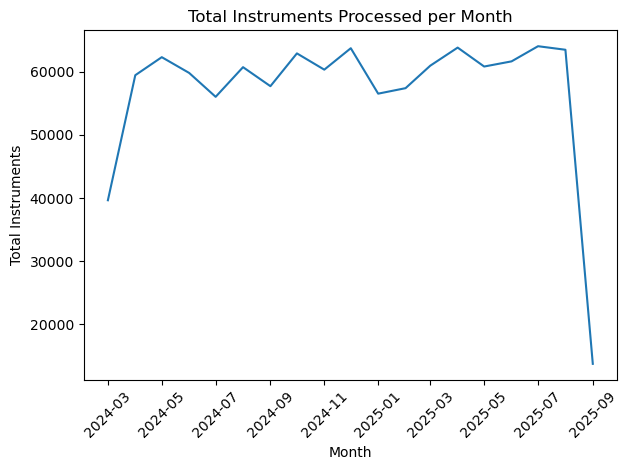

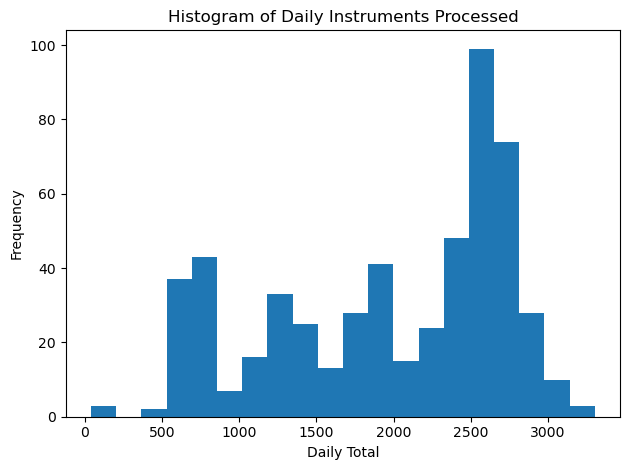

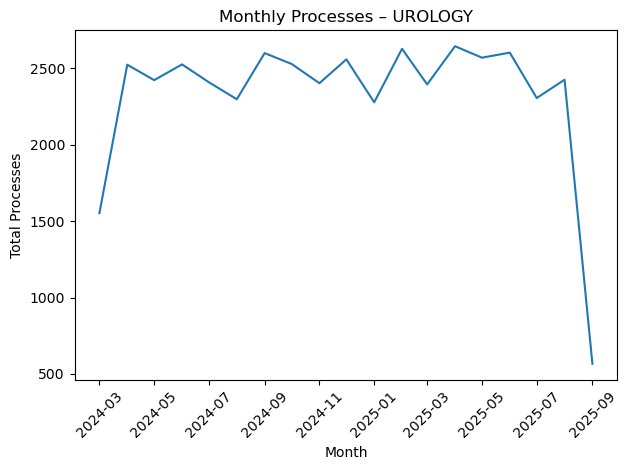

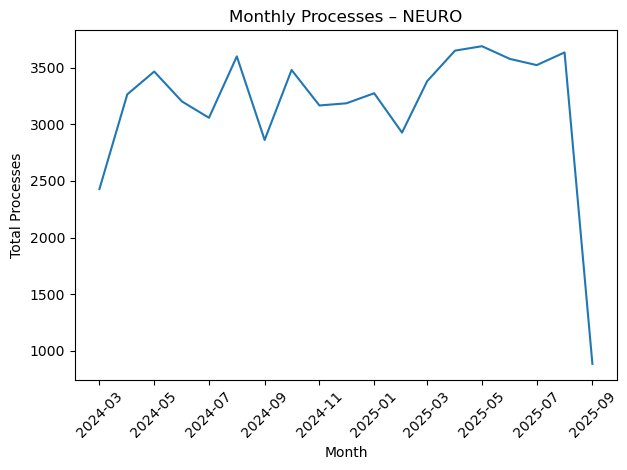

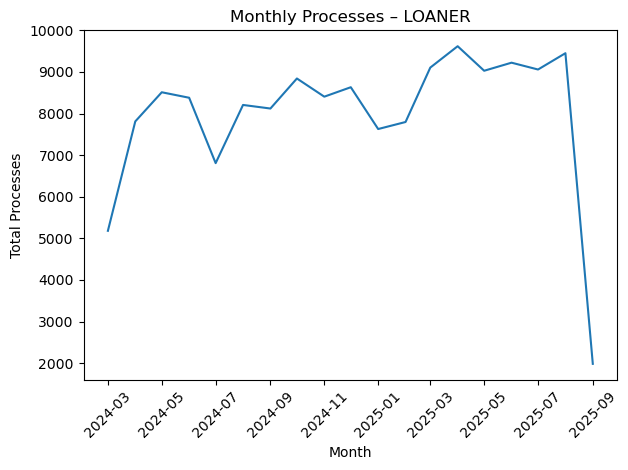

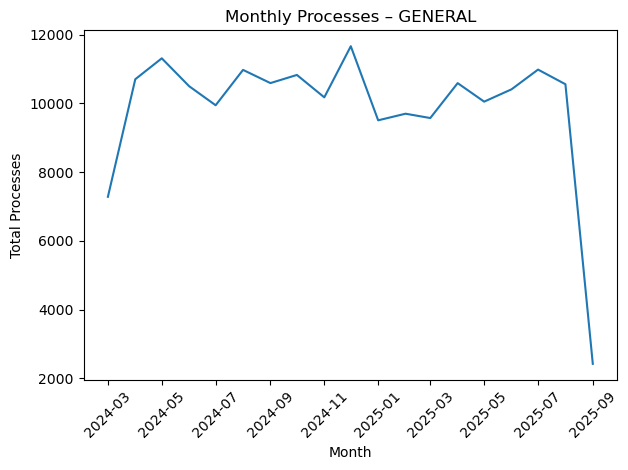

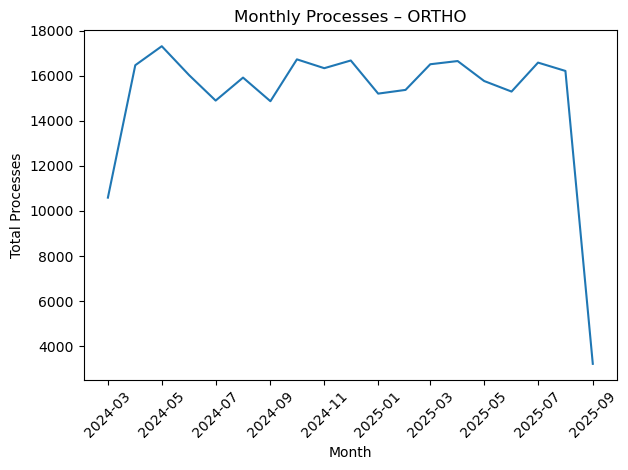

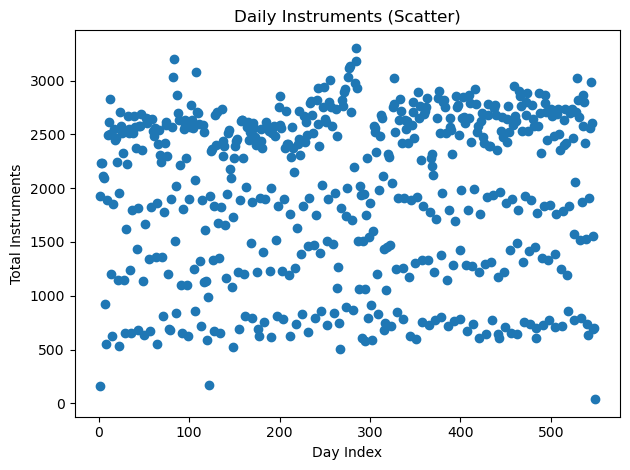

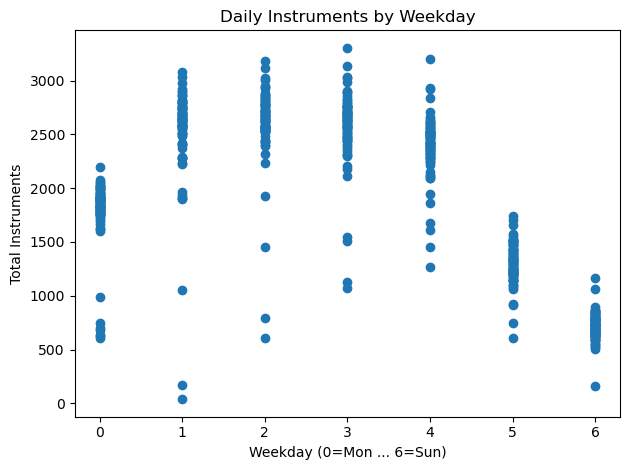

In [157]:
# --- 0) Speed up conversions with Arrow (optional but recommended)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

import pyspark.sql.functions as F
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt

# ========== 1) Build small tables in Spark (safe to .toPandas()) ==========

# (a) Monthly totals (overall)
month_totals = (
    df_dates.groupBy("YearMonth")
            .agg(F.count(F.lit(1)).alias("TotalInstruments"))
            .orderBy("YearMonth")
)

# (b) Monthly totals by Service
svc_month = (
    df_dates.groupBy("ServiceNorm", "YearMonth")
            .agg(F.count(F.lit(1)).alias("TotalProcesses"))
            .orderBy("ServiceNorm", "YearMonth")
)

# (c) Daily totals (overall)
day_totals = (
    df_dates.groupBy("Day")
            .agg(F.count(F.lit(1)).alias("TotalInstruments"))
            .orderBy("Day")
)

# (d) (Optional) Top-N services by total count for focused visuals
topN = 5
top_services = (
    df_dates.groupBy("ServiceNorm")
            .agg(F.count(F.lit(1)).alias("Total"))
            .orderBy(F.desc("Total"))
            .limit(topN)
)
svc_month_top = (
    svc_month.join(F.broadcast(top_services.select("ServiceNorm")), "ServiceNorm", "inner")
)

# ========== 2) Convert to pandas ==========
month_totals_pd   = month_totals.toPandas()
svc_month_pd      = svc_month.toPandas()
svc_month_top_pd  = svc_month_top.toPandas()
day_totals_pd     = day_totals.toPandas()

# Parse dates for plotting
month_totals_pd["YearMonth"] = pd.to_datetime(month_totals_pd["YearMonth"], format="%Y-%m")
svc_month_pd["YearMonth"]    = pd.to_datetime(svc_month_pd["YearMonth"], format="%Y-%m")
svc_month_top_pd["YearMonth"]= pd.to_datetime(svc_month_top_pd["YearMonth"], format="%Y-%m")
day_totals_pd["Day"]         = pd.to_datetime(day_totals_pd["Day"], format="%Y-%m-%d")

# ========== 3) Matplotlib visuals (no seaborn) ==========

# A) Line chart: total instruments by month (overall)
plt.figure()
plt.plot(month_totals_pd["YearMonth"], month_totals_pd["TotalInstruments"])
plt.title("Total Instruments Processed per Month")
plt.xlabel("Month")
plt.ylabel("Total Instruments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# B) Histogram: distribution of daily totals
plt.figure()
plt.hist(day_totals_pd["TotalInstruments"], bins=20)
plt.title("Histogram of Daily Instruments Processed")
plt.xlabel("Daily Total")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# C) Service trend lines: one chart per top Service
#    (keeps charts readable & follows 'one plot per chart' guidance)
for svc in svc_month_top_pd["ServiceNorm"].unique():
    df_s = svc_month_top_pd[svc_month_top_pd["ServiceNorm"] == svc].sort_values("YearMonth")
    plt.figure()
    plt.plot(df_s["YearMonth"], df_s["TotalProcesses"])
    plt.title(f"Monthly Processes – {svc}")
    plt.xlabel("Month")
    plt.ylabel("Total Processes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# D) Scatter: daily totals vs. day index (quick anomaly check)
day_totals_pd = day_totals_pd.sort_values("Day").reset_index(drop=True)
day_totals_pd["DayIndex"] = range(1, len(day_totals_pd)+1)

plt.figure()
plt.scatter(day_totals_pd["DayIndex"], day_totals_pd["TotalInstruments"])
plt.title("Daily Instruments (Scatter)")
plt.xlabel("Day Index")
plt.ylabel("Total Instruments")
plt.tight_layout()
plt.show()

# (Optional) Scatter: weekday pattern
day_totals_pd["Weekday"] = day_totals_pd["Day"].dt.weekday  # 0=Mon ... 6=Sun
plt.figure()
plt.scatter(day_totals_pd["Weekday"], day_totals_pd["TotalInstruments"])
plt.title("Daily Instruments by Weekday")
plt.xlabel("Weekday (0=Mon ... 6=Sun)")
plt.ylabel("Total Instruments")
plt.tight_layout()
plt.show()


StatementMeta(, cd165b5e-8c51-4ad7-b713-4875d1320b20, 160, Finished, Available, Finished)

Top 10 Services by Total Volume:
  ServiceNorm   Total
0       ORTHO  286582
1     GENERAL  187812
2      LOANER  151796
3       NEURO   60284
4     UROLOGY   44223
5         GYN   43425
6    ROBOTICS   38594
7  DEPARTMENT   32739
8         L&D   29209
9          CV   27581


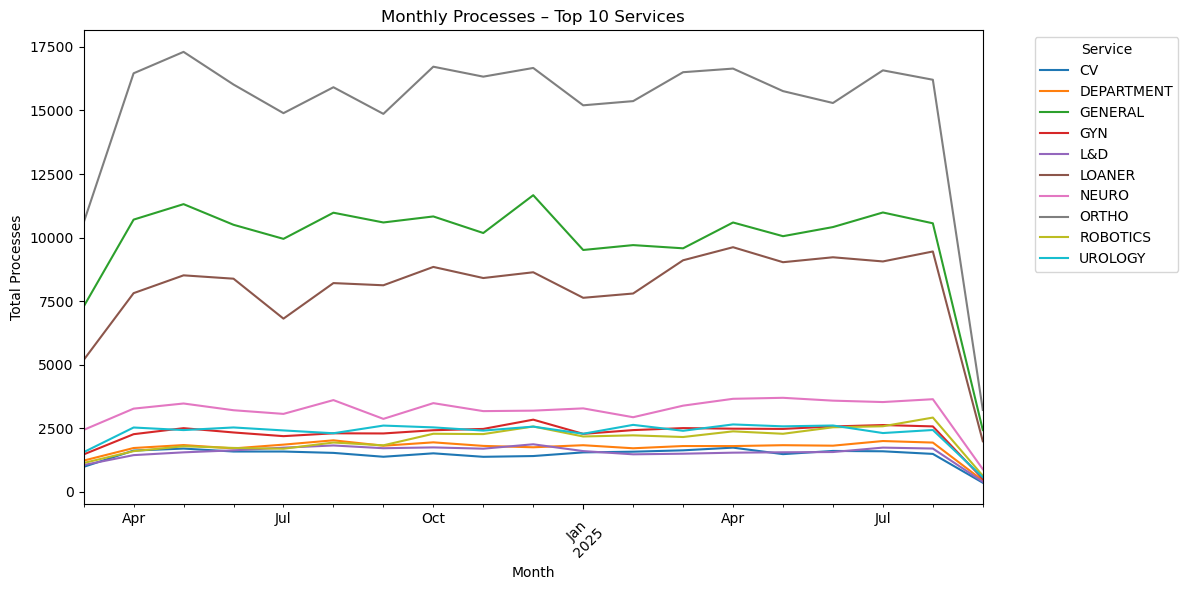

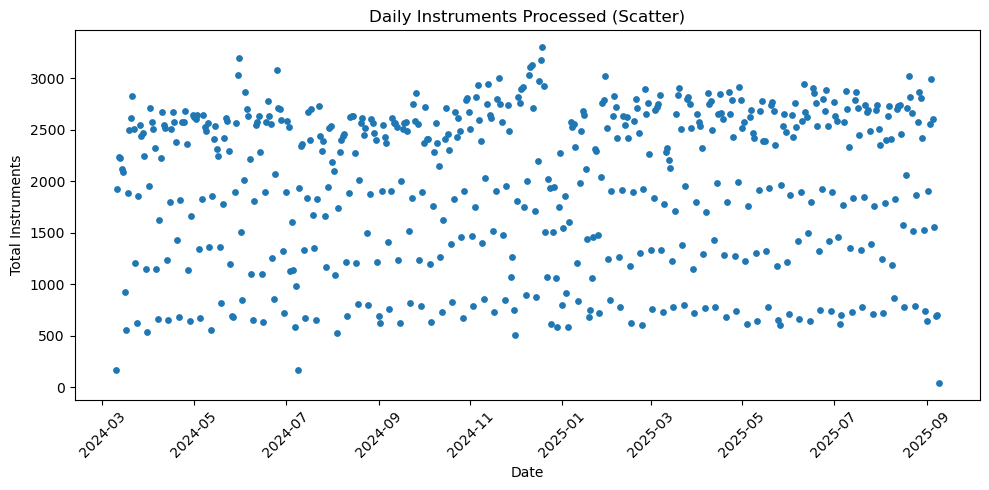

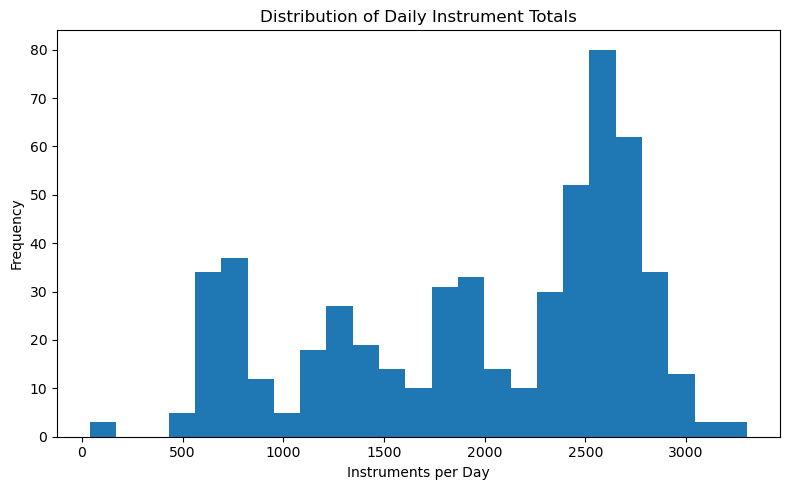

In [158]:
# --- 4) Top-10 services trend lines ------------------------------------------
top10_services = (
    df_dates.groupBy("ServiceNorm")
            .agg(F.count(F.lit(1)).alias("Total"))
            .orderBy(F.desc("Total"))
            .limit(10)
)
top10_pd = top10_services.toPandas().sort_values("Total", ascending=False)
print("Top 10 Services by Total Volume:")
print(top10_pd)

# Join with monthly table for plotting
svc_month_top10 = (
    svc_month.join(F.broadcast(top10_services.select("ServiceNorm")), "ServiceNorm", "inner")
             .orderBy("ServiceNorm", "YearMonth")
)
svc_month_top10_pd = svc_month_top10.toPandas()
svc_month_top10_pd["YearMonth"] = pd.to_datetime(svc_month_top10_pd["YearMonth"], format="%Y-%m")

# Multi-line chart (10 services)
pivot_df = svc_month_top10_pd.pivot(index="YearMonth", columns="ServiceNorm", values="TotalProcesses")
pivot_df.plot(figsize=(12,6))
plt.title("Monthly Processes – Top 10 Services")
plt.xlabel("Month")
plt.ylabel("Total Processes")
plt.xticks(rotation=45)
plt.legend(title="Service", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# --- 5) Overall daily variability --------------------------------------------
day_totals_pd = day_totals.toPandas()
day_totals_pd["Day"] = pd.to_datetime(day_totals_pd["Day"], format="%Y-%m-%d")
day_totals_pd = day_totals_pd.sort_values("Day").reset_index(drop=True)

# Scatter (each dot = 1 day)
plt.figure(figsize=(10,5))
plt.scatter(day_totals_pd["Day"], day_totals_pd["TotalInstruments"], s=15)
plt.title("Daily Instruments Processed (Scatter)")
plt.xlabel("Date")
plt.ylabel("Total Instruments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histogram (spread of daily totals)
plt.figure(figsize=(8,5))
plt.hist(day_totals_pd["TotalInstruments"], bins=25)
plt.title("Distribution of Daily Instrument Totals")
plt.xlabel("Instruments per Day")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


<mark>**Notes + Archived Code Below**</mark><mark></mark>

from pyspark.sql import functions as F

# ---------- Helpers you already had ----------
PLACEHOLDER_WORDS = ["PRIORITY","NEWLABEL","INACTIVE","SCRAP","TEST","UNKNOWN","DAMAGED"]

def name_core(col):
    x = F.upper(F.trim(col.cast("string")))
    x = F.regexp_replace(x, r"[0-9]", "")
    x = F.regexp_replace(x, r"\b(SET|TRAY|BASKET|LID|CASE|INSERT|KIT|REV|REVISION|VER|V|SMALL|MEDIUM|LARGE)\b", " ")
    x = F.regexp_replace(x, r"\s+", " ")
    x = F.regexp_replace(x, r"[^0-9A-Z]", "")
    return x

def serial8_from_any(col):
    run = F.regexp_extract(col, r"(\d{8,})", 1)
    return F.when(F.length(run) >= 8, F.reverse(F.substring(F.reverse(run), 1, 8)))

def add_serial_variants(df):
    d = df
    if "SerialKey" in d.columns:
        d = d.withColumn(
            "SerialKey_raw",
            F.when(F.trim("SerialKey").isin("", "BLANK","NULL","N/A","NA"), None).otherwise(F.col("SerialKey"))
        ).withColumn(
            "tmp_serial_squeezed",
            F.upper(F.regexp_replace(F.trim(F.col("SerialKey_raw")), r"[^0-9A-Za-z]", ""))
        ).withColumn(
            "tmp_serial_squeezed",
            F.when(F.upper(F.col("tmp_serial_squeezed")).isin(*PLACEHOLDER_WORDS), None)
             .otherwise(F.col("tmp_serial_squeezed"))
        ).withColumn(
            "Serial8", serial8_from_any(F.col("tmp_serial_squeezed"))
        ).drop("tmp_serial_squeezed")
    return d

def add_name_variants(df):
    d = df
    if "NameKey" in d.columns:
        d = d.withColumn("NameCore", name_core(F.col("NameKey")))
    return d

# ---------- Make inv_all safe even if prep cells didn't run ----------
def ensure_inv_columns(df):
    d = df
    # ContainerIndex_src
    if "ContainerIndex_src" not in d.columns:
        if "Container Index" in d.columns:
            d = d.withColumn(
                "ContainerIndex_src",
                F.when(
                    F.trim(F.col("Container Index").cast("string")).isin("", "BLANK", "NULL", "N/A", "NA"),
                    None
                ).otherwise(F.col("Container Index").cast("string"))
            )
        else:
            d = d.withColumn("ContainerIndex_src", F.lit(None).cast("string"))

    # FacilityKey
    if "FacilityKey" not in d.columns and "Facility" in d.columns:
        d = d.withColumn(
            "FacilityKey",
            F.regexp_replace(
                F.regexp_replace(
                    F.regexp_replace(
                        F.upper(F.trim(F.col("Facility").cast("string"))),
                        r"^(MH|MEMORIAL HERMANN)\s+", ""
                    ),
                    r"\s*\bTHE MEDICAL CENTER\s*\d*\b", "THE MEDICAL CENTER"
                ),
                r"\s+", " "
            )
        )

    # NameKey / ActualKey / SerialKey
    for want, src in [
        ("NameKey",   "Container Name"),
        ("ActualKey", "Container Actual"),
        ("SerialKey", "Container Barcode"),
    ]:
        if want not in d.columns:
            if src in d.columns:
                d = d.withColumn(
                    want,
                    F.upper(
                        F.regexp_replace(
                            F.regexp_replace(F.trim(F.col(src).cast("string")), r"\s+", " "),
                            r"[^0-9A-Za-z]", ""
                        )
                    )
                )
            else:
                d = d.withColumn(want, F.lit(None).cast("string"))

    return d

# ---------- Build invX (balanced parentheses) ----------
inv_all_safe = ensure_inv_columns(inv_all)

invX = (
    inv_all_safe
        .withColumn(
            "ContainerIndex",
            F.coalesce(
                F.col("ContainerIndex_src"),
                F.expr("substring(sha2(cast(concat_ws('|', FacilityKey, NameKey, ActualKey, SerialKey) as binary), 256), 1, 16)")
            )
        )
        .dropna(subset=["NameKey"])
)
invX = add_serial_variants(add_name_variants(invX)).cache()

# ---------- Inventory maps ----------
inv_serial_map   = (
    invX.filter(F.col("SerialKey").rlike(r"^\d{8}$"))
        .select("FacilityKey","SerialKey","ContainerIndex")
        .dropDuplicates(["FacilityKey","SerialKey"])
        .withColumnRenamed("ContainerIndex","CI_ser")
)
inv_serial8_map  = (
    invX.filter(F.col("Serial8").isNotNull())
        .select("FacilityKey","Serial8","ContainerIndex")
        .dropDuplicates(["FacilityKey","Serial8"])
        .withColumnRenamed("ContainerIndex","CI_ser8")
)
inv_name_map     = (
    invX.filter(F.col("NameKey").isNotNull())
        .select("FacilityKey","NameKey","ContainerIndex")
        .dropDuplicates(["FacilityKey","NameKey"])
        .withColumnRenamed("ContainerIndex","CI_name")
)
inv_namecore_map = (
    invX.filter(F.col("NameCore").isNotNull())
        .select("FacilityKey","NameCore","ContainerIndex")
        .dropDuplicates(["FacilityKey","NameCore"])
        .withColumnRenamed("ContainerIndex","CI_namecore")
)

# ---------- Attacher (indentation fixed) ----------
def attach_idx(df, label):
    d = df

    # ensure the columns we join on exist for ALL datasets
    if "ContainerIndex_src" not in d.columns:
        d = d.withColumn("ContainerIndex_src", F.lit(None).cast("string"))
    if "SerialKey" not in d.columns:
        d = d.withColumn("SerialKey", F.lit(None).cast("string"))
    if "NameKey" not in d.columns:
        d = d.withColumn("NameKey", F.lit(None).cast("string"))

    # derive variants
    d = add_serial_variants(add_name_variants(d)).alias("d")

    j = (
        d
        .join(F.broadcast(inv_serial_map).alias("s"),
              (F.col("d.FacilityKey")==F.col("s.FacilityKey")) &
              (F.col("d.SerialKey")==F.col("s.SerialKey")), "left")
        .join(F.broadcast(inv_serial8_map).alias("s8"),
              (F.col("d.FacilityKey")==F.col("s8.FacilityKey")) &
              (F.col("d.Serial8")==F.col("s8.Serial8")), "left")
        .join(F.broadcast(inv_name_map).alias("n"),
              (F.col("d.FacilityKey")==F.col("n.FacilityKey")) &
              (F.col("d.NameKey")==F.col("n.NameKey")), "left")
        .join(F.broadcast(inv_namecore_map).alias("nc"),
              (F.col("d.FacilityKey")==F.col("nc.FacilityKey")) &
              (F.col("d.NameCore")==F.col("nc.NameCore")), "left")
        .withColumn(
            "ContainerIndex",
            F.coalesce(
                F.col("d.ContainerIndex_src"),
                F.col("s.CI_ser"), F.col("s8.CI_ser8"),
                F.col("n.CI_name"), F.col("nc.CI_namecore")
            )
        )
        .select("d.*", "ContainerIndex", "s.CI_ser", "s8.CI_ser8", "n.CI_name", "nc.CI_namecore")
    )

    print(f"Attached index to {label}")
    return j


# --- Build & report ---
st_with_idx = attach_idx(st_all, "ST").cache()
gi_with_idx = attach_idx(gi_all, "GI").cache()
pd_with_idx = attach_idx(pd_all, "PD").cache()
mi_with_idx = attach_idx(mi_all, "MI").cache()

def coverage(df, label):
    tot = df.count()
    got = df.filter("ContainerIndex is not null").count()
    pct = (got / tot * 100) if tot else 0
    print(f"{label}: {got:,}/{tot:,} ({pct:.1f}%) with ContainerIndex")

coverage(st_with_idx, "ST")
coverage(gi_with_idx, "GI")
coverage(pd_with_idx, "PD")
coverage(mi_with_idx, "MI")

for label, df in [("ST", st_with_idx), ("GI", gi_with_idx), ("PD", pd_with_idx), ("MI", mi_with_idx)]:
    cols = [c for c in ["CI_ser","CI_ser8","CI_name","CI_namecore"] if c in df.columns]
    agg = df.agg(*(F.sum(F.col(c).isNotNull().cast("int")).alias(c) for c in cols))
    print(label); agg.show(truncate=False)


# Rebuild
st_with_idx = attach_idx(st_all, "ST").cache()
gi_with_idx = attach_idx(gi_all, "GI").cache()
pd_with_idx = attach_idx(pd_all, "PD").cache()
mi_with_idx = attach_idx(mi_all, "MI").cache()

# Coverage
for label, df in [("ST", st_with_idx), ("GI", gi_with_idx), ("PD", pd_with_idx), ("MI", mi_with_idx)]:
    tot = df.count()
    got = df.filter("ContainerIndex is not null").count()
    print(f"{label}: {got:,}/{tot:,} ({got/tot*100:.1f}%)")

# Contribution by path
for label, df in [("ST", st_with_idx), ("GI", gi_with_idx), ("PD", pd_with_idx), ("MI", mi_with_idx)]:
    cols = [c for c in ["CI_ser","CI_ser8","CI_name","CI_namecore"] if c in df.columns]
    print(label); df.agg(*(F.sum(F.col(c).isNotNull().cast("int")).alias(c) for c in cols)).show(truncate=False)


from pyspark.sql import functions as F

# 1A) Alias → NameCore for GI/PD
def alias_core(col):
    # same cleaning logic as name_core, but for Alias-like fields
    x = F.upper(F.trim(col.cast("string")))
    x = F.regexp_replace(x, r"[0-9]", "")
    x = F.regexp_replace(x, r"\b(SET|TRAY|BASKET|LID|CASE|INSERT|KIT|REV|REVISION|VER|V|SMALL|MEDIUM|LARGE)\b", " ")
    x = F.regexp_replace(x, r"\s+", " ")
    x = F.regexp_replace(x, r"[^0-9A-Z]", "")
    return x

def with_alias_core(df, alias_col_name):
    d = df
    if alias_col_name in d.columns:
        d = d.withColumn("AliasCore", alias_core(F.col(alias_col_name)))
    else:
        d = d.withColumn("AliasCore", F.lit(None).cast("string"))
    return d

# Add AliasCore to your sources that have Alias
gi_all_ac = with_alias_core(gi_all, "Alias")
pd_all_ac = with_alias_core(pd_all, "Alias")  # PD shows an Alias column in your plan

# 1B) Build PD→CI maps (PD is already ~92% covered, leverage it as a dictionary)
pdX = (pd_all_ac
       .withColumn("NameCore", name_core(F.col("NameKey")))
       .withColumn("FacilityKey", F.col("FacilityKey")))  # keep naming consistent

# Join PD to inventory like you did (re-use your attach_idx if you want a PD-with-CI quickly)
pd_with_idx = attach_idx(pdX, "PD_for_maps").cache()

pd_namecore_fac = (pd_with_idx
    .filter(F.col("ContainerIndex").isNotNull() & F.col("NameCore").isNotNull())
    .select("FacilityKey","NameCore","ContainerIndex")
    .dropDuplicates(["FacilityKey","NameCore"])
    .withColumnRenamed("ContainerIndex","CI_pd_nc_fac")
)

pd_aliascore_fac = (pd_with_idx
    .filter(F.col("ContainerIndex").isNotNull() & F.col("AliasCore").isNotNull())
    .select("FacilityKey","AliasCore","ContainerIndex")
    .dropDuplicates(["FacilityKey","AliasCore"])
    .withColumnRenamed("ContainerIndex","CI_pd_ac_fac")
)

# 1C) Facility-agnostic UNAMBIGUOUS maps (inventory + PD)
# Inventory NameCore (global unique)
inv_namecore_any = (inv_namecore_map
    .groupBy("NameCore")
    .agg(F.countDistinct("CI_namecore").alias("nCI"), F.first("CI_namecore").alias("CI_one"))
    .filter("nCI=1")
    .select(F.col("NameCore"), F.col("CI_one").alias("CI_inv_nc_any"))
)

# PD NameCore (global unique)
pd_namecore_any = (pd_with_idx
    .filter(F.col("ContainerIndex").isNotNull() & F.col("NameCore").isNotNull())
    .groupBy("NameCore")
    .agg(F.countDistinct("ContainerIndex").alias("nCI"), F.first("ContainerIndex").alias("CI_one"))
    .filter("nCI=1")
    .select(F.col("NameCore"), F.col("CI_one").alias("CI_pd_nc_any"))
)

# PD AliasCore (global unique)
pd_aliascore_any = (pd_with_idx
    .filter(F.col("ContainerIndex").isNotNull() & F.col("AliasCore").isNotNull())
    .groupBy("AliasCore")
    .agg(F.countDistinct("ContainerIndex").alias("nCI"), F.first("ContainerIndex").alias("CI_one"))
    .filter("nCI=1")
    .select(F.col("AliasCore"), F.col("CI_one").alias("CI_pd_ac_any"))
)


def attach_idx_plus(df, label):
    d = df
    if "ContainerIndex_src" not in d.columns:
        d = d.withColumn("ContainerIndex_src", F.lit(None).cast("string"))
    if "SerialKey" not in d.columns:
        d = d.withColumn("SerialKey", F.lit(None).cast("string"))
    if "NameKey" not in d.columns:
        d = d.withColumn("NameKey", F.lit(None).cast("string"))

    # derive variants
    d = add_serial_variants(add_name_variants(d))
    # add AliasCore if the dataset has an Alias column
    d = with_alias_core(d, "Alias").alias("d")

    j = (
        d
        # 1) Serial exact / Serial8 (facility)
        .join(F.broadcast(inv_serial_map).alias("s"),
              (F.col("d.FacilityKey")==F.col("s.FacilityKey")) &
              (F.col("d.SerialKey")==F.col("s.SerialKey")), "left")
        .join(F.broadcast(inv_serial8_map).alias("s8"),
              (F.col("d.FacilityKey")==F.col("s8.FacilityKey")) &
              (F.col("d.Serial8")==F.col("s8.Serial8")), "left")

        # 2) NameCore strict (facility) – inventory map
        .join(F.broadcast(inv_name_map).alias("n"),
              (F.col("d.FacilityKey")==F.col("n.FacilityKey")) &
              (F.col("d.NameKey")==F.col("n.NameKey")), "left")

        # 3) NameCore relaxed (facility) – inventory map
        .join(F.broadcast(inv_namecore_map).alias("nc"),
              (F.col("d.FacilityKey")==F.col("nc.FacilityKey")) &
              (F.col("d.NameCore")==F.col("nc.NameCore")), "left")

        # 4) PD dictionary (facility): NameCore & AliasCore
        .join(F.broadcast(pd_namecore_fac).alias("pdnc"),
              (F.col("d.FacilityKey")==F.col("pdnc.FacilityKey")) &
              (F.col("d.NameCore")==F.col("pdnc.NameCore")), "left")
        .join(F.broadcast(pd_aliascore_fac).alias("pdac"),
              (F.col("d.FacilityKey")==F.col("pdac.FacilityKey")) &
              (F.col("d.AliasCore")==F.col("pdac.AliasCore")), "left")

        # 5) Facility-agnostic UNAMBIGUOUS fallbacks
        .join(F.broadcast(inv_namecore_any).alias("nc_any"),
              F.col("d.NameCore")==F.col("nc_any.NameCore"), "left")
        .join(F.broadcast(pd_namecore_any).alias("pdnc_any"),
              F.col("d.NameCore")==F.col("pdnc_any.NameCore"), "left")
        .join(F.broadcast(pd_aliascore_any).alias("pdac_any"),
              F.col("d.AliasCore")==F.col("pdac_any.AliasCore"), "left")

        .withColumn(
            "ContainerIndex",
            F.coalesce(
                # native CI if present
                F.col("d.ContainerIndex_src"),
                # serials (rare for ST, but cheap to try)
                F.col("s.CI_ser"), F.col("s8.CI_ser8"),
                # facility-scoped names (inventory)
                F.col("n.CI_name"), F.col("nc.CI_namecore"),
                # facility-scoped names (PD dictionary)
                F.col("pdnc.CI_pd_nc_fac"), F.col("pdac.CI_pd_ac_fac"),
                # global unique fallbacks (inventory + PD)
                F.col("nc_any.CI_inv_nc_any"),
                F.col("pdnc_any.CI_pd_nc_any"),
                F.col("pdac_any.CI_pd_ac_any"),
            )
        )
        .select(
            "d.*", "ContainerIndex",
            # optional diagnostics
            "s.CI_ser","s8.CI_ser8","n.CI_name","nc.CI_namecore",
            "pdnc.CI_pd_nc_fac","pdac.CI_pd_ac_fac",
            "nc_any.CI_inv_nc_any","pdnc_any.CI_pd_nc_any","pdac_any.CI_pd_ac_any"
        )
    )

    print(f"Attached index+ to {label}")
    return j


st_with_idx = attach_idx_plus(st_all, "ST").cache()
gi_with_idx = attach_idx_plus(gi_all, "GI").cache()
pd_with_idx = attach_idx_plus(pd_all_ac, "PD").cache()  # PD already high; this keeps it
mi_with_idx = attach_idx_plus(mi_all, "MI").cache()

for label, df in [("ST", st_with_idx), ("GI", gi_with_idx), ("PD", pd_with_idx), ("MI", mi_with_idx)]:
    tot = df.count()
    got = df.filter("ContainerIndex is not null").count()
    print(f"{label}: {got:,}/{tot:,} ({got/tot*100:.1f}%)")


from pyspark.sql import functions as F

# --- inventory: Reference ID -> CI (facility) ---
inv_ref_fac = (invX
    .filter(F.col("Reference ID").isNotNull())
    .select("FacilityKey", F.col("Reference ID").alias("RefID"), "ContainerIndex")
    .dropDuplicates(["FacilityKey", "RefID"])
    .withColumnRenamed("ContainerIndex", "CI_inv_ref_fac")
)

# also a global-unique Reference ID fallback (facility-agnostic, only if unambiguous)
inv_ref_any = (invX
    .filter(F.col("Reference ID").isNotNull())
    .groupBy(F.col("Reference ID").alias("RefID"))
    .agg(F.countDistinct("ContainerIndex").alias("nCI"),
         F.first("ContainerIndex").alias("CI_one"))
    .filter("nCI = 1")
    .select("RefID", F.col("CI_one").alias("CI_inv_ref_any"))
)

# --- PD is 100% CI: build strict maps we didn’t use before ---
pd_strict = pd_with_idx  # you already built this earlier; it has ContainerIndex

# NameKey (strict) at facility
pd_name_fac = (pd_strict
    .filter(F.col("ContainerIndex").isNotNull() & F.col("NameKey").isNotNull())
    .select("FacilityKey", "NameKey", "ContainerIndex")
    .dropDuplicates(["FacilityKey", "NameKey"])
    .withColumnRenamed("ContainerIndex", "CI_pd_name_fac")
)

# Alias (strict) at facility (use upper/trim to normalize a bit)
pd_alias_fac = (pd_strict
    .filter(F.col("ContainerIndex").isNotNull() & F.col("Alias").isNotNull())
    .select("FacilityKey",
            F.upper(F.trim(F.col("Alias"))).alias("Alias_strict"),
            "ContainerIndex")
    .dropDuplicates(["FacilityKey", "Alias_strict"])
    .withColumnRenamed("ContainerIndex", "CI_pd_alias_fac")
)

# Catalog Number at facility
pd_cat_fac = (pd_strict
    .filter(F.col("ContainerIndex").isNotNull() & F.col("Catalog Number").isNotNull())
    .select("FacilityKey",
            F.upper(F.trim(F.col("Catalog Number"))).alias("CatNum"),
            "ContainerIndex")
    .dropDuplicates(["FacilityKey", "CatNum"])
    .withColumnRenamed("ContainerIndex", "CI_pd_cat_fac")
)

# Global-unique fallbacks (only if unambiguous across all facilities)
pd_alias_any = (pd_strict
    .filter(F.col("ContainerIndex").isNotNull() & F.col("Alias").isNotNull())
    .groupBy(F.upper(F.trim(F.col("Alias"))).alias("Alias_strict"))
    .agg(F.countDistinct("ContainerIndex").alias("nCI"),
         F.first("ContainerIndex").alias("CI_one"))
    .filter("nCI = 1")
    .select("Alias_strict", F.col("CI_one").alias("CI_pd_alias_any"))
)

pd_cat_any = (pd_strict
    .filter(F.col("ContainerIndex").isNotNull() & F.col("Catalog Number").isNotNull())
    .groupBy(F.upper(F.trim(F.col("Catalog Number"))).alias("CatNum"))
    .agg(F.countDistinct("ContainerIndex").alias("nCI"),
         F.first("ContainerIndex").alias("CI_one"))
    .filter("nCI = 1")
    .select("CatNum", F.col("CI_one").alias("CI_pd_cat_any"))
)


def attach_idx_plus(df, label):
    d = df
    if "ContainerIndex_src" not in d.columns:
        d = d.withColumn("ContainerIndex_src", F.lit(None).cast("string"))
    if "SerialKey" not in d.columns:
        d = d.withColumn("SerialKey", F.lit(None).cast("string"))
    if "NameKey" not in d.columns:
        d = d.withColumn("NameKey", F.lit(None).cast("string"))

    # derive variants you already have
    d = add_serial_variants(add_name_variants(d))
    d = with_alias_core(d, "Alias")

    # normalize extra GI keys (RefID, CatNum, Alias_strict) if present
    d = (d
         .withColumn("RefID", F.upper(F.trim(F.col("Reference ID"))) if "Reference ID" in d.columns else F.lit(None))
         .withColumn("CatNum", F.upper(F.trim(F.col("Catalog Number"))) if "Catalog Number" in d.columns else F.lit(None))
         .withColumn("Alias_strict", F.upper(F.trim(F.col("Alias"))) if "Alias" in d.columns else F.lit(None))
    ).alias("d")

    j = (
        d
        # === your existing join stack (serials, name strict, name core, PD namecore/aliascore, etc.) ===
        .join(F.broadcast(inv_serial_map).alias("s"),
              (F.col("d.FacilityKey")==F.col("s.FacilityKey")) & (F.col("d.SerialKey")==F.col("s.SerialKey")), "left")
        .join(F.broadcast(inv_serial8_map).alias("s8"),
              (F.col("d.FacilityKey")==F.col("s8.FacilityKey")) & (F.col("d.Serial8")==F.col("s8.Serial8")), "left")
        .join(F.broadcast(inv_name_map).alias("n"),
              (F.col("d.FacilityKey")==F.col("n.FacilityKey")) & (F.col("d.NameKey")==F.col("n.NameKey")), "left")
        .join(F.broadcast(inv_namecore_map).alias("nc"),
              (F.col("d.FacilityKey")==F.col("nc.FacilityKey")) & (F.col("d.NameCore")==F.col("nc.NameCore")), "left")
        .join(F.broadcast(pd_namecore_fac).alias("pdnc"),
              (F.col("d.FacilityKey")==F.col("pdnc.FacilityKey")) & (F.col("d.NameCore")==F.col("pdnc.NameCore")), "left")
        .join(F.broadcast(pd_aliascore_fac).alias("pdac"),
              (F.col("d.FacilityKey")==F.col("pdac.FacilityKey")) & (F.col("d.AliasCore")==F.col("pdac.AliasCore")), "left")

        # === NEW: high-signal GI keys (facility-scoped first) ===
        .join(F.broadcast(inv_ref_fac).alias("irf"),
              (F.col("d.FacilityKey")==F.col("irf.FacilityKey")) & (F.col("d.RefID")==F.col("irf.RefID")), "left")
        .join(F.broadcast(pd_name_fac).alias("pdfn"),
              (F.col("d.FacilityKey")==F.col("pdfn.FacilityKey")) & (F.col("d.NameKey")==F.col("pdfn.NameKey")), "left")
        .join(F.broadcast(pd_alias_fac).alias("pdfa"),
              (F.col("d.FacilityKey")==F.col("pdfa.FacilityKey")) & (F.col("d.Alias_strict")==F.col("pdfa.Alias_strict")), "left")
        .join(F.broadcast(pd_cat_fac).alias("pdfc"),
              (F.col("d.FacilityKey")==F.col("pdfc.FacilityKey")) & (F.col("d.CatNum")==F.col("pdfc.CatNum")), "left")

        # === global-unique fallbacks (only if unambiguous) ===
        .join(F.broadcast(inv_namecore_any).alias("nc_any"),
              F.col("d.NameCore")==F.col("nc_any.NameCore"), "left")
        .join(F.broadcast(pd_namecore_any).alias("pdnc_any"),
              F.col("d.NameCore")==F.col("pdnc_any.NameCore"), "left")
        .join(F.broadcast(pd_aliascore_any).alias("pdac_any"),
              F.col("d.AliasCore")==F.col("pdac_any.AliasCore"), "left")
        .join(F.broadcast(inv_ref_any).alias("irf_any"),
              F.col("d.RefID")==F.col("irf_any.RefID"), "left")
        .join(F.broadcast(pd_alias_any).alias("pdfa_any"),
              F.col("d.Alias_strict")==F.col("pdfa_any.Alias_strict"), "left")
        .join(F.broadcast(pd_cat_any).alias("pdfc_any"),
              F.col("d.CatNum")==F.col("pdfc_any.CatNum"), "left")

        .withColumn(
            "ContainerIndex",
            F.coalesce(
                F.col("d.ContainerIndex_src"),

                # serials
                F.col("s.CI_ser"), F.col("s8.CI_ser8"),

                # inventory names (facility)
                F.col("n.CI_name"), F.col("nc.CI_namecore"),

                # PD dictionaries (facility)
                F.col("pdnc.CI_pd_nc_fac"), F.col("pdac.CI_pd_ac_fac"),

                # NEW: inventory RefID + PD stricts (facility)
                F.col("irf.CI_inv_ref_fac"),
                F.col("pdfn.CI_pd_name_fac"),    # NameKey strict
                F.col("pdfa.CI_pd_alias_fac"),   # Alias strict
                F.col("pdfc.CI_pd_cat_fac"),     # Catalog Number

                # global unique fallbacks (safe)
                F.col("nc_any.CI_inv_nc_any"),
                F.col("pdnc_any.CI_pd_nc_any"),
                F.col("pdac_any.CI_pd_ac_any"),
                F.col("irf_any.CI_inv_ref_any"),
                F.col("pdfa_any.CI_pd_alias_any"),
                F.col("pdfc_any.CI_pd_cat_any"),
            )
        )
        .select(
            "d.*", "ContainerIndex",
            # optional diagnostics:
            "irf.CI_inv_ref_fac","pdfn.CI_pd_name_fac","pdfa.CI_pd_alias_fac","pdfc.CI_pd_cat_fac",
            "irf_any.CI_inv_ref_any","pdfa_any.CI_pd_alias_any","pdfc_any.CI_pd_cat_any"
        )
    )
    print(f"Attached index+ (GI-boost) to {label}")
    return j


gi_with_idx = attach_idx_plus(gi_all, "GI").cache()

tot = gi_with_idx.count()
got = gi_with_idx.filter("ContainerIndex is not null").count()
print(f"GI: {got:,}/{tot:,} ({got/tot*100:.1f}%)")


<mark>**Notes + Archived Code Below**</mark>

from pyspark.sql import functions as F, Window as W

def canon_fac(col):
    c = F.upper(F.trim(col))
    c = F.regexp_replace(c, r'^(MH|MEMORIAL HERMANN)\s+', '')        # strip MH/Memorial Hermann
    c = F.regexp_replace(c, r'\s*\bTHE MEDICAL CENTER\s*\d*\b', 'THE MEDICAL CENTER')  # collapse TMC 1/2/3
    c = F.regexp_replace(c, r'\s+', ' ')
    return c

def norm_key(col):
    return F.upper(F.regexp_replace(F.regexp_replace(F.trim(col), r"\s+", " "), r"[^0-9A-Za-z]", ""))

def null_if_blank(c):
    return F.when(F.trim(F.col(c)).isin("", "BLANK","NULL","N/A","NA"), None).otherwise(F.col(c))



# --- inv_bridge (source of truth) ---
inv_name = pick_ci(inv_all.columns, "Container Name")
inv_act  = pick_ci(inv_all.columns, "Container Actual")
inv_bar  = pick_ci(inv_all.columns, "Container Barcode", "Container Serial Number", "Serial #", "Serial")

inv_all = (inv_all
    .withColumn("Facility", F.coalesce(F.col(pick_ci(inv_all.columns, "Facility","Hospital","Site")), F.lit("UNKNOWN")))
    .withColumn("FacilityKey", canon_fac(F.col("Facility")))
    .withColumn("NameKey",   norm_key(F.col(inv_name)) if inv_name else F.lit(None))
    .withColumn("ActualKey", norm_key(F.col(inv_act))  if inv_act  else F.lit(None))
    .withColumn("SerialKey", norm_key(F.col(inv_bar))  if inv_bar  else F.lit(None))
)

inv_idx_src = pick_ci(inv_all.columns, "Container Index", "ContainerIndex")
inv_all = inv_all.withColumn("ContainerIndex_src", null_if_blank(inv_idx_src) if inv_idx_src else F.lit(None))

inv_bridge = (inv_all
    .withColumn("ContainerIndex",
        F.coalesce(
            F.col("ContainerIndex_src"),
            F.expr("substring(sha2(cast(concat_ws('|', FacilityKey, NameKey, ActualKey, SerialKey) as binary), 256), 1, 16)")
        )
    )
    .dropna(subset=["NameKey"])
    .dropDuplicates(["FacilityKey","NameKey","ActualKey","SerialKey","ContainerIndex"])
    .cache()
)

# --- maps (only select what you need, avoid duplicate-named cols) ---
w_ser = W.partitionBy("FacilityKey","SerialKey").orderBy(F.col("ContainerIndex"))
w_act = W.partitionBy("FacilityKey","ActualKey").orderBy(F.col("ContainerIndex"))
w_nam = W.partitionBy("FacilityKey","NameKey").orderBy(F.col("ContainerIndex"))

map_ser_fac = (inv_bridge.filter(F.col("SerialKey").isNotNull())
    .withColumn("rn", F.row_number().over(w_ser)).filter("rn=1").drop("rn")
    .select("FacilityKey","SerialKey", F.col("ContainerIndex").alias("m1_CI"))
    .dropDuplicates(["FacilityKey","SerialKey"])
    .cache()
)

map_act_fac = (inv_bridge.filter(F.col("ActualKey").isNotNull())
    .withColumn("rn", F.row_number().over(w_act)).filter("rn=1").drop("rn")
    .select("FacilityKey","ActualKey", F.col("ContainerIndex").alias("m2_CI"))
    .dropDuplicates(["FacilityKey","ActualKey"])
    .cache()
)

map_nam_fac = (inv_bridge.filter(F.col("NameKey").isNotNull())
    .withColumn("rn", F.row_number().over(w_nam)).filter("rn=1").drop("rn")
    .select("FacilityKey","NameKey", F.col("ContainerIndex").alias("m3_CI"))
    .dropDuplicates(["FacilityKey","NameKey"])
    .cache()
)

# facility-agnostic fallbacks
w_ser2 = W.partitionBy("SerialKey").orderBy(F.col("ContainerIndex"))
w_act2 = W.partitionBy("ActualKey").orderBy(F.col("ContainerIndex"))
w_nam2 = W.partitionBy("NameKey").orderBy(F.col("ContainerIndex"))

map_ser_any = (inv_bridge.filter(F.col("SerialKey").isNotNull())
    .withColumn("rn", F.row_number().over(w_ser2)).filter("rn=1").drop("rn")
    .select(F.col("SerialKey").alias("SerialKey_any"), F.col("ContainerIndex").alias("a1_CI"))
    .cache()
)
map_act_any = (inv_bridge.filter(F.col("ActualKey").isNotNull())
    .withColumn("rn", F.row_number().over(w_act2)).filter("rn=1").drop("rn")
    .select(F.col("ActualKey").alias("ActualKey_any"), F.col("ContainerIndex").alias("a2_CI"))
    .cache()
)
map_nam_any = (inv_bridge.filter(F.col("NameKey").isNotNull())
    .withColumn("rn", F.row_number().over(w_nam2)).filter("rn=1").drop("rn")
    .select(F.col("NameKey").alias("NameKey_any"), F.col("ContainerIndex").alias("a3_CI"))
    .cache()
)



def attach_index_smart(df, label):
    d = df.alias("d")

    # make sure the left side always has the columns we join on / coalesce
    if "FacilityKey" not in d.columns:
        d = d.withColumn(
            "FacilityKey",
            canon_fac(F.coalesce(F.col("Facility"), F.lit("UNKNOWN")))
        )
    if "SerialKey" not in d.columns:
        d = d.withColumn("SerialKey", F.lit(None).cast("string"))
    if "NameKey" not in d.columns:
        d = d.withColumn("NameKey", F.lit(None).cast("string"))
    if "ActualKey" not in d.columns:                         # <-- THIS fixes your error
        d = d.withColumn("ActualKey", F.lit(None).cast("string"))
    if "ContainerIndex_src" not in d.columns:
        d = d.withColumn("ContainerIndex_src", F.lit(None).cast("string"))

    # now do your joins…
    j = (d
         .join(F.broadcast(map_ser_fac).alias("m1"),
               (F.col("d.FacilityKey")==F.col("m1.FacilityKey")) &
               (F.col("d.SerialKey")==F.col("m1.SerialKey")), "left")
         .join(F.broadcast(map_act_fac).alias("m2"),
               (F.col("d.FacilityKey")==F.col("m2.FacilityKey")) &
               (F.col("d.ActualKey")==F.col("m2.ActualKey")), "left")
         .join(F.broadcast(map_nam_fac).alias("m3"),
               (F.col("d.FacilityKey")==F.col("m3.FacilityKey")) &
               (F.col("d.NameKey")==F.col("m3.NameKey")), "left")
         .join(F.broadcast(map_ser_any).alias("a1"),
               F.col("d.SerialKey")==F.col("a1.SerialKey_any"), "left")
         .join(F.broadcast(map_act_any).alias("a2"),
               F.col("d.ActualKey")==F.col("a2.ActualKey_any"), "left")
         .join(F.broadcast(map_nam_any).alias("a3"),
               F.col("d.NameKey")==F.col("a3.NameKey_any"), "left")
         .select(
             F.col("d.*"),
             F.col("m1.m1_CI"), F.col("m2.m2_CI"), F.col("m3.m3_CI"),
             F.col("a1.a1_CI"), F.col("a2.a2_CI"), F.col("a3.a3_CI")
         )
    )

    j = j.withColumn(
        "ContainerIndex",
        F.coalesce(
            F.col("ContainerIndex_src"),
            F.col("m1_CI"), F.col("m2_CI"), F.col("m3_CI"),
            F.col("a1_CI"), F.col("a2_CI"), F.col("a3_CI")
        )
    )

    return j



map_ser_fac = inv_bridge.select("Facility","SerialKey","ContainerIndex")

inv_bridge = inv_bridge.withColumn("FacilityKey", canon_fac(F.col("Facility")))

map_ser_fac = (inv_bridge.filter(F.col("SerialKey").isNotNull())
    .select("FacilityKey","SerialKey", F.col("ContainerIndex").alias("m1_CI"))
    .dropDuplicates(["FacilityKey","SerialKey"])
    .cache())

map_act_fac = (inv_bridge.filter(F.col("ActualKey").isNotNull())
    .select("FacilityKey","ActualKey", F.col("ContainerIndex").alias("m2_CI"))
    .dropDuplicates(["FacilityKey","ActualKey"])
    .cache())

map_nam_fac = (inv_bridge.filter(F.col("NameKey").isNotNull())
    .select("FacilityKey","NameKey", F.col("ContainerIndex").alias("m3_CI"))
    .dropDuplicates(["FacilityKey","NameKey"])
    .cache())


def attach_index_smart(df, label):
    d = df.alias("d")

    # Ensure left side has all keys we join on / coalesce
    if "FacilityKey" not in d.columns:
        d = d.withColumn("FacilityKey", canon_fac(F.coalesce(F.col("Facility"), F.lit("UNKNOWN"))))
    if "SerialKey" not in d.columns:
        d = d.withColumn("SerialKey", F.lit(None).cast("string"))
    if "NameKey" not in d.columns:
        d = d.withColumn("NameKey", F.lit(None).cast("string"))
    if "ActualKey" not in d.columns:
        d = d.withColumn("ActualKey", F.lit(None).cast("string"))
    if "ContainerIndex_src" not in d.columns:
        d = d.withColumn("ContainerIndex_src", F.lit(None).cast("string"))

    # <- IMPORTANT: re-alias after withColumn so 'd.' works below
    d = d.alias("d")

    j = (d
         .join(F.broadcast(map_ser_fac).alias("m1"),
               (F.col("d.FacilityKey")==F.col("m1.FacilityKey")) &
               (F.col("d.SerialKey")==F.col("m1.SerialKey")), "left")
         .join(F.broadcast(map_act_fac).alias("m2"),
               (F.col("d.FacilityKey")==F.col("m2.FacilityKey")) &
               (F.col("d.ActualKey")==F.col("m2.ActualKey")), "left")
         .join(F.broadcast(map_nam_fac).alias("m3"),
               (F.col("d.FacilityKey")==F.col("m3.FacilityKey")) &
               (F.col("d.NameKey")==F.col("m3.NameKey")), "left")
         .join(F.broadcast(map_ser_any).alias("a1"),
               F.col("d.SerialKey")==F.col("a1.SerialKey_any"), "left")
         .join(F.broadcast(map_act_any).alias("a2"),
               F.col("d.ActualKey")==F.col("a2.ActualKey_any"), "left")
         .join(F.broadcast(map_nam_any).alias("a3"),
               F.col("d.NameKey")==F.col("a3.NameKey_any"), "left")
    )

    j = (j
         .withColumn("ContainerIndex", F.coalesce(
             F.col("d.ContainerIndex_src"),
             F.col("m1.ContainerIndex"), F.col("m2.ContainerIndex"), F.col("m3.ContainerIndex"),
             F.col("a1.CI_ser_any"), F.col("a2.CI_act_any"), F.col("a3.CI_nam_any")
         ))
         .drop("m1.FacilityKey","m1.SerialKey","m1.ContainerIndex",
               "m2.FacilityKey","m2.ActualKey","m2.ContainerIndex",
               "m3.FacilityKey","m3.NameKey","m3.ContainerIndex",
               "a1.SerialKey_any","a1.CI_ser_any",
               "a2.ActualKey_any","a2.CI_act_any",
               "a3.NameKey_any","a3.CI_nam_any")
    )
    return j



# Add FacilityKey to sources
def with_facility_key(df, fac_col_name):
    return (df
        .withColumn("Facility", F.coalesce(F.col(fac_col_name), F.lit("UNKNOWN")))
        .withColumn("FacilityKey", canon_fac(F.col("Facility")))
    )

gi_all = with_facility_key(gi_all, pick_ci(gi_all.columns,"Facility","Hospital","Site"))
pd_all = with_facility_key(pd_all, pick_ci(pd_all.columns,"Facility","Hospital","Site"))
st_all = with_facility_key(st_all, pick_ci(st_all.columns,"Facility","Hospital","Site"))
mi_all = with_facility_key(mi_all, pick_ci(mi_all.columns,"Facility","Hospital","Site"))

def attach_index_smart(df, label):
    d = df.alias("d")  # stable left alias

    # join in ONLY the CI columns with distinct names to avoid dupes
    j = (d
        .join(F.broadcast(map_ser_fac).alias("m1"),
              (F.col("d.FacilityKey")==F.col("m1.FacilityKey")) & (F.col("d.SerialKey")==F.col("m1.SerialKey")),
              "left")
        .join(F.broadcast(map_act_fac).alias("m2"),
              (F.col("d.FacilityKey")==F.col("m2.FacilityKey")) & (F.col("d.ActualKey")==F.col("m2.ActualKey")),
              "left")
        .join(F.broadcast(map_nam_fac).alias("m3"),
              (F.col("d.FacilityKey")==F.col("m3.FacilityKey")) & (F.col("d.NameKey")==F.col("m3.NameKey")),
              "left")
        .join(F.broadcast(map_ser_any).alias("a1"),
              F.col("d.SerialKey")==F.col("a1.SerialKey_any"), "left")
        .join(F.broadcast(map_act_any).alias("a2"),
              F.col("d.ActualKey")==F.col("a2.ActualKey_any"), "left")
        .join(F.broadcast(map_nam_any).alias("a3"),
              F.col("d.NameKey")==F.col("a3.NameKey_any"), "left")
        .select(
            F.col("d.*"),
            F.col("m1.m1_CI"), F.col("m2.m2_CI"), F.col("m3.m3_CI"),
            F.col("a1.a1_CI"), F.col("a2.a2_CI"), F.col("a3.a3_CI")
        )
    )

    # ContainerIndex_src might not exist on d; coalesce handles that
    j = j.withColumn(
        "ContainerIndex",
        F.coalesce(
            F.col("ContainerIndex_src"),
            F.col("m1_CI"), F.col("m2_CI"), F.col("m3_CI"),
            F.col("a1_CI"), F.col("a2_CI"), F.col("a3_CI")
        )
    )

    # optional: quick hit diagnostics
    j = j.withColumn("hit_serial", F.when(F.col("m1_CI").isNotNull() | F.col("a1_CI").isNotNull(), 1).otherwise(0)) \
         .withColumn("hit_name",   F.when(F.col("m3_CI").isNotNull() | F.col("a3_CI").isNotNull(), 1).otherwise(0)) \
         .withColumn("hit_actual", F.when(F.col("m2_CI").isNotNull() | F.col("a2_CI").isNotNull(), 1).otherwise(0))

    print(f"Attached index to {label}")
    return j



# once on inv_bridge
inv_bridge = inv_bridge.withColumn("FacilityKey", canon_fac(F.col("Facility")))

map_ser_fac = (inv_bridge.filter(F.col("SerialKey").isNotNull())
    .select("FacilityKey","SerialKey","ContainerIndex").dropDuplicates(["FacilityKey","SerialKey"]).cache())

map_act_fac = (inv_bridge.filter(F.col("ActualKey").isNotNull())
    .select("FacilityKey","ActualKey","ContainerIndex").dropDuplicates(["FacilityKey","ActualKey"]).cache())

map_nam_fac = (inv_bridge.filter(F.col("NameKey").isNotNull())
    .select("FacilityKey","NameKey","ContainerIndex").dropDuplicates(["FacilityKey","NameKey"]).cache())


### Normalize Keys (system wide)

def norm_key(col):
    return F.upper(F.regexp_replace(F.regexp_replace(F.trim(col), r"\s+", " "), r"[^0-9A-Za-z]", ""))

# Inventory (source of truth)
inv_all = (inv_all
    .withColumn("NameKey",   norm_key(F.col("Container Name")))
    .withColumn("ActualKey", norm_key(F.col("Container Actual")))
    .withColumn("SerialKey", norm_key(F.col("Container Barcode")))
)

# GI
gi_all = (gi_all
    .withColumn("NameKey",   norm_key(F.col("Container Name")))
    .withColumn("SerialKey", norm_key(F.col("Container Barcode")) if "Container Barcode" in gi_all.columns else F.lit(None))
)

# PD (Container or Container Name depending on site)
pd_name_col = "Container" if "Container" in pd_all.columns else "Container Name"
pd_all = pd_all.withColumn("NameKey", norm_key(F.col(pd_name_col)))

# ST
st_all = (st_all
    .withColumn("SerialKey", norm_key(F.col("Container Serial Number")))
    .withColumn("NameKey",   norm_key(F.col("Container")) if "Container" in st_all.columns else F.lit(None))
)

# MI
mi_name_col = "Container" if "Container" in mi_all.columns else ("Container Name" if "Container Name" in mi_all.columns else None)
mi_all = mi_all.withColumn("NameKey", norm_key(F.col(mi_name_col)) if mi_name_col else F.lit(None))


### Build the system wide inventory bridge (+ optional ContainerIndex)

# Respect existing Container Index if present and not blank
null_if_blank = lambda c: F.when(F.trim(F.col(c)).isin("", "BLANK", "NULL", "N/A", "NA"), None).otherwise(F.col(c))

inv_all = inv_all.withColumn("ContainerIndex_src", null_if_blank("Container Index") if "Container Index" in inv_all.columns else F.lit(None))

inv_bridge = (inv_all
    .withColumn("ContainerIndex",
        F.coalesce(
            F.col("ContainerIndex_src"),
            F.expr("substring(sha2(cast(concat_ws('|', NameKey, ActualKey, SerialKey, Facility) as binary), 256), 1, 16)")
        )
    )
    .dropna(subset=["NameKey"])                       # must have at least NameKey
    .dropDuplicates(["NameKey","ActualKey","SerialKey","Facility"])
    .cache()
)
print("inv_bridge rows:", inv_bridge.count())


EXCLUDE = ["LOANER","STERILE PROCESSING","OUTSIDE SERVICE","DEPARTMENT","ZZ_DATABASE CLEANUP","zz_DATABASE CLEANUP"]
def exclude_services(df):
    return df.filter(~F.upper(F.col("Service")).isin(EXCLUDE)) if "Service" in df.columns else df

gi_all_f  = exclude_services(gi_all)
pd_all_f  = exclude_services(pd_all)
st_all_f  = exclude_services(st_all)
mi_all_f  = exclude_services(mi_all)


#Attach ContainerIndex to each dataset SerialKey -> ActualKey -> NameKey

# Helper: join to bridge within Facility
def attach_index(df, alias):
    b = inv_bridge.select("Facility","SerialKey","ActualKey","NameKey","ContainerIndex")
    j = df.alias(alias)
    # try SerialKey
    if "SerialKey" in df.columns:
        j = (j.join(b.select(F.col("Facility").alias("bf"), F.col("SerialKey").alias("js"), F.col("ContainerIndex").alias("CI_s")),
                    (F.col(f"{alias}.Facility")==F.col("bf")) & (F.col(f"{alias}.SerialKey")==F.col("js")),
                    "left"))
    else:
        j = j.withColumn("CI_s", F.lit(None))

    # try ActualKey
    if "ActualKey" in df.columns:
        j = (j.join(b.select(F.col("Facility").alias("bf2"), F.col("ActualKey").alias("ja"), F.col("ContainerIndex").alias("CI_a")),
                    (F.col(f"{alias}.Facility")==F.col("bf2")) & (F.col(f"{alias}.ActualKey")==F.col("ja")),
                    "left"))
    else:
        j = j.withColumn("CI_a", F.lit(None))

    # try NameKey
    if "NameKey" in df.columns:
        j = (j.join(b.select(F.col("Facility").alias("bf3"), F.col("NameKey").alias("jn"), F.col("ContainerIndex").alias("CI_n")),
                    (F.col(f"{alias}.Facility")==F.col("bf3")) & (F.col(f"{alias}.NameKey")==F.col("jn")),
                    "left"))
    else:
        j = j.withColumn("CI_n", F.lit(None))

    # respect existing Container Index if present
    existing = "Container Index" if "Container Index" in df.columns else ( "ContainerIndex" if "ContainerIndex" in df.columns else None )
    if existing:
        j = j.withColumn("ContainerIndex_src", null_if_blank(existing))
    else:
        j = j.withColumn("ContainerIndex_src", F.lit(None))

    out = (j.withColumn("ContainerIndex", F.coalesce("ContainerIndex_src","CI_s","CI_a","CI_n"))
             .drop("bf","bf2","bf3","js","ja","jn","CI_s","CI_a","CI_n","ContainerIndex_src"))
    return out

gi_with_idx = attach_index(gi_all_f, "gi").cache()
pd_with_idx = attach_index(pd_all_f, "pd").cache()
st_with_idx = attach_index(st_all_f, "st").cache()
mi_with_idx = attach_index(mi_all_f, "mi").cache()

# Coverage check
def coverage(df, label):
    total = df.count()
    with_idx = df.filter(F.col("ContainerIndex").isNotNull()).count()
    print(f"{label}: {with_idx:,}/{total:,} ({with_idx*100.0/total:.1f}%) with ContainerIndex")

coverage(inv_bridge, "dim_container")
coverage(gi_with_idx, "gi_with_idx")
coverage(pd_with_idx, "pd_with_idx")
coverage(st_with_idx, "st_with_idx")
coverage(mi_with_idx, "mi_with_idx")


# Pick a timestamp column in ST and normalize it
st_ts_col = "Sterilized Date/Time" if "Sterilized Date/Time" in st_with_idx.columns else None
if st_ts_col:
    st_fact = (st_with_idx
        .withColumn("ST_ts",
            F.to_timestamp(F.col(st_ts_col), "MM/dd/yyyy HH:mm:ss"))
        .withColumn("Date", F.to_date("ST_ts"))
        .dropna(subset=["ContainerIndex"])  # keep only rows we can star-key
        .cache()
    )
else:
    st_fact = st_with_idx.dropna(subset=["ContainerIndex"]).cache()

# Small GI & PD dimension slices (one row per ContainerIndex, pick latest by something if needed)
from pyspark.sql import Window

w_ci = Window.partitionBy("ContainerIndex").orderBy(F.col("Added").cast("timestamp").desc() if "Added" in gi_with_idx.columns else F.lit(0))

gi_dim = (gi_with_idx
    .withColumn("rn", F.row_number().over(w_ci))
    .filter("rn=1").drop("rn")
    .select("ContainerIndex","Facility","Service","Sterilization Method","Container Type Status","Packaging Type")
    .dropDuplicates(["ContainerIndex"])
)

pd_dim = (pd_with_idx
    .groupBy("ContainerIndex","Facility","Service")
    .agg(F.max(F.col("# of sets")).alias("PD_Sets") if "# of sets" in pd_with_idx.columns else F.first(F.lit(None)).alias("PD_Sets"),
         F.max(F.col("Total Ext. Qty")).alias("PD_TotalQty") if "Total Ext. Qty" in pd_with_idx.columns else F.first(F.lit(None)).alias("PD_TotalQty"))
)

# Final star join (left since fact is big)
fact_star = (st_fact.alias("f")
    .join(gi_dim.alias("gi"), on=["ContainerIndex","Facility","Service"], how="left")
    .join(pd_dim.alias("pd"), on=["ContainerIndex","Facility","Service"], how="left")
    .cache()
)

print("fact_star rows:", fact_star.count())
fact_star.printSchema()


# Daily volume by Facility (filtered set)
(fact_star.groupBy("Facility","Date")
    .count().orderBy("Facility","Date")
    .show(15, False))

# Pass rate by Facility (if Load Result exists)
if "Load Result" in fact_star.columns:
    kpi = (fact_star
      .withColumn("pass", F.when(F.upper(F.col("Load Result")).like("%PASS%"), 1).otherwise(0))
      .groupBy("Facility")
      .agg(F.count("*").alias("N"), F.sum("pass").alias("PassN"),
           (F.sum("pass")/F.count("*")).alias("PassRate"))
      .orderBy(F.desc("PassRate")))
    kpi.show(20, False)
